In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="0"


from keras.layers import Dense, Input, Dropout, BatchNormalization
from keras.models import Model, Sequential

from keras.regularizers import l2, l1, l1_l2


import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping


import pickle


2025-03-16 22:04:30.709262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-16 22:04:30.725505: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8463] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-16 22:04:30.730447: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import optree
import keras
print( '\n\n')
print(' optree version:  %s' % str(optree.__version__))
print(' keras version:  %s' % str(keras.__version__))
print('\n\n')




 optree version:  0.13.0
 keras version:  3.4.1





In [3]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.26.4
  tensorflow version:  2.17.0





In [4]:
from keras.layers import Activation

beta = 4

def custom_activation(x):
    return 0.5 * x * (1 + K.tanh( beta * 0.79788 * (x + 0.044715 * x * x * x)))

## Set model and resolution parameters

In [5]:
##====================

ndim = 1

n_boot_samples = 500


resolution_sf = 1.00

output_dir = 'output-run-nn-study-nd-v0e-ndim%d-res-sf-%.2f' % (ndim, resolution_sf)


##-------------

if ndim == 6 :

    mc_mu = [ 1.,  0.,  -0.5,   0.5, -1., 0.3 ]

    mc_rho = [ 
                  [0.0, 0.0, -0.3, 0.2, 0.1],  #0
                  [0.1, 0.3, -0.2, 0.0 ],   #1
                  [0.3, -0.2, 0.1   ],  #2
                  [0.0, 0.1],  #3
                  [0.7],  #4
                ]

    mc_sig = [ 1., 0.7, 1.1, 0.8, 1.2, 1.4 ]


    ##-------------

    true_mu = [ 0.8,  0.1,  -0.6, 0.7, -0.8, 0.1 ]

    true_rho  = [ [0.0, 0.1, -0.2, 0.2, 0.0 ], #0
                  [0.0, 0.2, -0.1, 0.0],  #1
                  [0.4, -0.3, 0.0   ],  #2
                  [0.0, 0.2],  #3
                  [0.5],  #4
                ]

    true_sig = [ 0.8, 0.6, 1.0,    0.6, 1.0, 1.1 ]
    
    
    
    resolution = [ 0.4, 0.5, 0.6,   0.3, 0.4, 0.4  ]
    
    

##-------------

if ndim == 4 :
    
    mc_mu = [ 1.,  0.,  -0.5,   0.5 ]

    mc_rho = [ 
                  [0.3, -0.2, 0.1   ],  #0
                  [0.0, 0.1],  #1
                  [0.7],  #2
                ]

    mc_sig = [ 1., 0.7, 1.1, 0.8 ]
    
    
    ##-------------

    true_mu = [ 0.8,  0.1,  -0.6, 0.7 ]

    true_rho  = [ 
                  [0.4, -0.3, 0.0   ],  #0
                  [0.0, 0.2],  #1
                  [0.5],  #2
                ]

    true_sig = [ 0.8, 0.6, 1.0,    0.6 ]
    
    
    resolution = [ 0.4, 0.5, 0.6,   0.3  ]
    
    

##-------------

if ndim == 2 :
    
    mc_mu = [ 0.0, 1.0 ]

    mc_rho = [ [-0.6] ]

    mc_sig = [ 1.0, 1.5 ]


    ##-------------

    true_mu = [ 0.2, 0.8 ]

    true_rho  = [ [-0.6] ]

    true_sig = [ 0.9, 1.3 ]
    
    
    resolution = [ 0.5, 0.8  ]

    
##-------------

if ndim == 1 :

    ##-------------

    mc_mu = [ 0.0 ]

    mc_rho = [ [0.0] ]

    mc_sig = [ 1.0 ]


    ##-------------


    true_mu = [ 0.2 ]

    true_rho  = [ [0.0] ]

    true_sig = [ 0.9 ]  

    
    resolution = [ 0.5  ]









##=====================


#-- scale resolution 

for i in range( len(resolution) ) :
    resolution[i] = resolution_sf * resolution[i]
print('\n\n Resolution: %s\n\n' % str(resolution))


mc_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n mc covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            mc_cov[i][j] = mc_sig[i] * mc_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, mc_cov[i][j]))
        else :
            k = ndim - j - 1
            mc_cov[i][j] = mc_sig[i] * mc_sig[j] * mc_rho[i][k]
            mc_cov[j][i] = mc_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, mc_sig[i], mc_sig[j], mc_rho[i][k], mc_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
                






ngen_mc = 100000
ngen_true =  10000



of_niter = 5

learning_rate_setval = 0.0005





epochs_setval = 400

patience_setval = 25



use_batch_norm = False

units_per_layer = 50


number_of_layers = 3




dropout_setval = 0.0


batch_size_setval = int( ngen_true )






#activation_setval = 'relu'

activation_setval = custom_activation





do_bootstrap = False




use_poisson_fluctuations_around_ngen_true = True


random_seed = 1




save_step2_model = True




 Resolution: [0.5]





 mc covariance:
   0,  0 : diagonal    1.0000



 True covariance:
   0,  0 : diagonal    0.8100


In [6]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()

In [7]:
print("\n\n")
print("mc covariance determinant:  %f" % np.linalg.det( mc_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




mc covariance determinant:  1.000000
True covariance determinant:   0.810000





In [8]:
mc_cov_inv = np.linalg.inv( mc_cov )

In [9]:
mc_cov_inv_test = np.matmul( mc_cov, mc_cov_inv )

In [10]:
print("\n\n")
print(" mc covariance")
print( mc_cov )
print("\n mc covariance inverse")
print( mc_cov_inv )
print("\n mc covariance inverse test")
print(mc_cov_inv_test)
print("\n\n")




 mc covariance
[[1.]]

 mc covariance inverse
[[1.]]

 mc covariance inverse test
[[1.]]





In [11]:
true_cov_inv = np.linalg.inv( true_cov )

In [12]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [13]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[0.81]]

 True covariance inverse
[[1.2345679]]

 True covariance inverse test
[[1.]]





## Generate samples, save events and config

In [14]:

np.random.seed( random_seed )
keras.utils.set_random_seed( random_seed )


mc_pts = np.random.multivariate_normal(mc_mu, mc_cov, size=ngen_mc)


this_ngen_true = ngen_true
if use_poisson_fluctuations_around_ngen_true : this_ngen_true = np.random.poisson( ngen_true )

true_pts = np.random.multivariate_normal(true_mu, true_cov, size=this_ngen_true)


mc_det_pts = np.random.normal( mc_pts, resolution )

true_det_pts = np.random.normal( true_pts, resolution )



In [15]:
with open( '%s/mc-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, mc_pts)
    np.save(f, mc_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [16]:
with open('%s/config-pars.pkl' % output_dir, 'wb') as f :
    pickle.dump( mc_mu, f)
    pickle.dump( mc_rho, f)
    pickle.dump( mc_sig, f)
    pickle.dump( true_mu,f)
    pickle.dump( true_rho,f)
    pickle.dump( true_sig,f)
    pickle.dump( resolution,f)
    pickle.dump( mc_cov,f)
    pickle.dump( true_cov,f)


In [17]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_mc %d\n' % ngen_mc )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )
config_file.write('learning_rate_setval  %f\n' % learning_rate_setval )
config_file.write('epochs_setval  %d\n' % epochs_setval )
config_file.write('batch_size_setval  %d\n' % batch_size_setval )
config_file.write('use_poisson_fluctuations_around_total : %s\n' % str(use_poisson_fluctuations_around_ngen_true) )
config_file.write( 'random_seed:  %d\n' % random_seed  )
config_file.write('activation_setval  %s\n' % activation_setval )
config_file.write('beta  %s\n' % beta )


config_file.write('\n\n')
config_file.write('mc_mu : %s\n' % str(mc_mu))
config_file.write('mc_rho : %s\n' % str(mc_rho))
config_file.write('mc_sig : %s\n' % str(mc_sig))
config_file.write('mc_cov : %s\n' % str(mc_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution_sf :  %.2f\n' % resolution_sf )
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/config.txt

2025-03-16 22:04:32.517141

ngen_mc 100000
ngen_true  10000
of_niter   5
ndim       1
learning_rate_setval  0.000500
epochs_setval  400
batch_size_setval  10000
use_poisson_fluctuations_around_total : True
random_seed:  1
activation_setval  <function custom_activation at 0x7538f7be3250>
beta  4


mc_mu : [0.0]
mc_rho : [[0.0]]
mc_sig : [1.0]
mc_cov : [[1.]]


true_mu : [0.2]
true_rho : [[0.0]]
true_sig : [0.9]
true_cov : [[0.81]]


resolution_sf :  1.00
resolution : [0.5]





## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

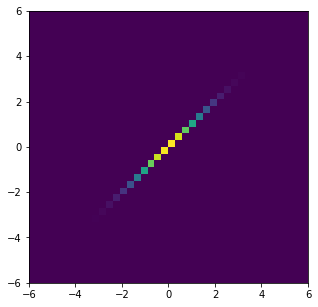

In [18]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim == 1 :
            axi = ax
        else :
            axi = ax[i][j]
        axi.hist2d( mc_pts[:,i], mc_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

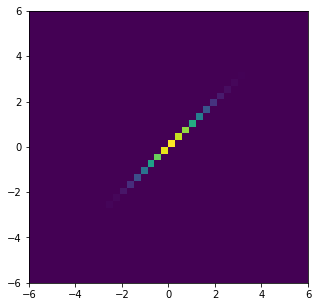

In [19]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim == 1 :
            axi = ax
        else :
            axi = ax[i][j]
        axi.hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

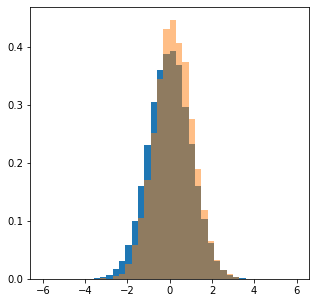

In [20]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        if ndim == 1 :
            axi = ax
        else :
            axi = ax[i]
        axi.hist( mc_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        axi.hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

## Set up NN model for OmniFold

In [21]:

import tensorflow.keras.backend as K


def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))

    return K.mean(t_loss)

In [22]:



from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(patience=patience_setval,
               verbose=True,
               restore_best_weights=True)







#-- off
l2reg_setval = 0.0





#-- off
al2reg_setval = 0.0




model_step1 = Sequential()

model_step1.add( Dense(units_per_layer, input_dim=ndim, activation=activation_setval, 
                       kernel_regularizer=l2(l2reg_setval), 
                       bias_regularizer=l2(l2reg_setval), 
                       activity_regularizer=l2(al2reg_setval) ) )
if use_batch_norm : model_step1.add( BatchNormalization() )
model_step1.add( Dropout(dropout_setval) )

if number_of_layers > 1 :
    model_step1.add( Dense(units_per_layer, activation=activation_setval, 
                       kernel_regularizer=l2(l2reg_setval), 
                       bias_regularizer=l2(l2reg_setval), 
                       activity_regularizer=l2(al2reg_setval) ) )
    if use_batch_norm : model_step1.add( BatchNormalization() )
    model_step1.add( Dropout(dropout_setval) )

if number_of_layers > 2 :
    model_step1.add( Dense(units_per_layer, activation=activation_setval, 
                       kernel_regularizer=l2(l2reg_setval), 
                       bias_regularizer=l2(l2reg_setval), 
                       activity_regularizer=l2(al2reg_setval) ) )
    if use_batch_norm : model_step1.add( BatchNormalization() )
    model_step1.add( Dropout(dropout_setval) )

model_step1.add( Dense(1, activation='sigmoid') )





model_step2 = Sequential()

model_step2.add( Dense(units_per_layer, input_dim=ndim, activation=activation_setval, 
                       kernel_regularizer=l2(l2reg_setval), 
                       bias_regularizer=l2(l2reg_setval), 
                       activity_regularizer=l2(al2reg_setval) ) )
if use_batch_norm : model_step2.add( BatchNormalization() )
model_step2.add( Dropout(dropout_setval) )

if number_of_layers > 1 :
    model_step2.add( Dense(units_per_layer, activation=activation_setval, 
                       kernel_regularizer=l2(l2reg_setval), 
                       bias_regularizer=l2(l2reg_setval), 
                       activity_regularizer=l2(al2reg_setval) ) )
    if use_batch_norm : model_step2.add( BatchNormalization() )
    model_step2.add( Dropout(dropout_setval) )

if number_of_layers > 2 :
    model_step2.add( Dense(units_per_layer, activation=activation_setval, 
                       kernel_regularizer=l2(l2reg_setval), 
                       bias_regularizer=l2(l2reg_setval), 
                       activity_regularizer=l2(al2reg_setval) ) )
    if use_batch_norm : model_step2.add( BatchNormalization() )
    model_step2.add( Dropout(dropout_setval) )

model_step2.add( Dense(1, activation='sigmoid') )


#----






opt_step1 = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )
opt_step2 = tf.keras.optimizers.Adam( learning_rate=(0.04*learning_rate_setval) )  # owen: use lower learning rate in step 2

model_step1.compile(loss=weighted_binary_crossentropy,
                      optimizer=opt_step1,
                      metrics=['accuracy'])

model_step2.compile(loss=weighted_binary_crossentropy,
                      optimizer=opt_step2,
                      metrics=['accuracy'])

print('\n\n ------ model_step1:')
model_step1.summary()

print('\n\n ------ model_step2:')
model_step2.summary()



/usr/lib/python3/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1742187872.828518   40132 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742187872.872386   40132 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742187872.872684   40132 cuda_executor.cc:1015] successful NUMA n



 ------ model_step1:


d negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742187872.954644   40132 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742187872.954863   40132 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-16 22:04:32.955052: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22079 MB memory:  -> device: 0, name: NVIDIA GeFor

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,251 (20.51 KB)

 Trainable params: 5,251 (20.51 KB)

 Non-trainable params: 0 (0.00 B)



 ------ model_step2:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,251 (20.51 KB)

 Trainable params: 5,251 (20.51 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
import optree
import keras
print(optree.__version__)
print(keras.__version__)

0.13.0
3.4.1


## Package the training data for OmniFold

In [24]:
mc_both = np.stack([mc_pts, mc_det_pts], axis=1)

## Define the OmniFold function

In [25]:
def reweight(events,model,batch_size=10000):
    f = model.predict(events, batch_size=batch_size, verbose=0)
    epsilon = K.epsilon()
    f = K.clip( f, epsilon, 1. - epsilon )  #owen: protect against divide by zero.
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights))


In [26]:
def omnifold(theta0,theta_unknown_S,iterations, model_step1, model_step2, verbose=0,
             batch_size_setval=10000, epochs_setval=20,
             save_step2_model=False, output_dir="./", patience_setval=5 ):

    weights = np.empty(shape=(iterations, 2, len(theta0)))
    # shape = (iteration, step, event)
    push_weights_for_output = np.empty(shape=(iterations, len(theta0)))

    theta0_G = theta0[:,0]
    theta0_S = theta0[:,1]

    labels0 = np.zeros(len(theta0))
    labels_unknown = np.ones(len(theta_unknown_S))
    labels_unknown_step2 = np.ones(len(theta0_G))

    premc_xvals_1 = np.concatenate((theta0_S, theta0_S))
    premc_yvals_1 = np.concatenate( (np.ones(len(theta0_S)), np.zeros(len(theta0_S))) )
    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))

    premc_xvals_2 = np.concatenate((theta0_G, theta0_G))
    premc_yvals_2 = np.concatenate( (np.ones(len(theta0_G)), np.zeros(len(theta0_G))) )
    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels_unknown_step2))

    if verbose :
        print("\n\n")
        print("  ======== omnifold\n\n")
        print("  shape of theta0_S : %s" % str(np.shape(theta0_S)) ) ;
        print("  shape of theta_unknown_S : %s" % str(np.shape(theta_unknown_S)) ) ;
        print("  shape of xvals_1 :  %s" % str(np.shape( xvals_1 )) ) ;
        print("\n\n")
        print("  shape of labels0 : %s" % str(np.shape(labels0)) ) ;
        print("  shape of labels_unknown : %s" % str(np.shape(labels_unknown)) ) ;
        print("  shape of yvals_1 :  %s" % str(np.shape( yvals_1 )) ) ;
        print("\n\n")
        print("  shape of theta0_G : %s" % str(np.shape(theta0_G)) ) ;
        print("  shape of xvals_2 :  %s" % str(np.shape( xvals_2 )) ) ;
        print("  shape of yvals_2 :  %s" % str(np.shape( yvals_2 )) ) ;
        print("\n batch size setval  %d" % batch_size_setval )
        print(" epochs setval  %d" % epochs_setval )
        print("\n\n")

    # initial iterative weights are ones
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))


    # owen: rescale the MC weights to balance the two categories for step 1 in first iteration.
    mc_weight_sf = (1.*len(theta_unknown_S))/(1.*len(theta0_S))

    
    if verbose : print('\n\n Saving model weights for reinitialization\n\n')

    initial_s1_weights_fname = '%s/initial-model-weights-s1.weights.h5' % output_dir
    if verbose : print(' step 1 :  %s ' % initial_s1_weights_fname )
    model_step1.save_weights( initial_s1_weights_fname )

    initial_s2_weights_fname = '%s/initial-model-weights-s2.weights.h5' % output_dir
    if verbose : print(' step 1 :  %s ' % initial_s2_weights_fname )
    model_step2.save_weights( initial_s2_weights_fname )

    if verbose : print('\n\n')

        
    fitverbose = 0
    if verbose > 1 : fitverbose = 1
        
    

    return_dict = {}
    
#-----------------------

    for i in range(iterations):

        if (verbose>0):
            print("\nITERATION: {}\n".format(i + 1))
            pass

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data

        if (verbose>0):
            print("   -- ITERATION %d  STEP 1\n" % (i+1) )
            pass

        print(" weights_push at the beginning")
        print( weights_push )


        #--- reinitialize weights every time.
        print('    reloading initial model weights')
        model_step1.load_weights( initial_s1_weights_fname )
        model_step2.load_weights( initial_s2_weights_fname )

     # owen: put the scaling here so that weights_push keeps its meaning (order 1).
        weights_1 = np.concatenate((mc_weight_sf * weights_push, np.ones(len(theta_unknown_S))))

        X_mc_1, X_test_1, Y_mc_1, Y_test_1, w_mc_1, w_test_1 = train_test_split(xvals_1, yvals_1, weights_1)

        # zip ("hide") the weights with the labels
        Y_mc_1 = np.stack((Y_mc_1, w_mc_1), axis=1)
        Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)
        if i > -1 :

                premc_weights_1 = np.concatenate( (np.ones(len(theta0_S)), np.ones(len(theta0_S))) )

                pt_X_mc_1, pt_X_test_1, pt_Y_mc_1, pt_Y_test_1, pt_w_mc_1, pt_w_test_1 = train_test_split(premc_xvals_1, premc_yvals_1, premc_weights_1)

                pt_Y_mc_1 = np.stack((pt_Y_mc_1, pt_w_mc_1), axis=1)
                pt_Y_test_1 = np.stack((pt_Y_test_1, pt_w_test_1), axis=1)

                if verbose>0 :
                        print("             running pre-training, distinguish from self.")

                model_step1.fit( pt_X_mc_1, pt_Y_mc_1, epochs=5, batch_size=batch_size_setval, verbose=fitverbose )

                if verbose>0 :
                        print("             done pretraining.")

        this_epochs = epochs_setval
        if i == 0 : this_epochs = this_epochs*2
        
        earlystopping = EarlyStopping(patience=patience_setval, verbose=True, restore_best_weights=False)

        mc_history_step1 = model_step1.fit(X_mc_1,
                                              Y_mc_1,
                                              epochs=this_epochs,
                                              batch_size=batch_size_setval,
                                              validation_data=(X_test_1, Y_test_1),
                                              verbose=fitverbose,
                                              callbacks=[earlystopping]
                                             )

        step1_output_weights = reweight(theta0_S,model_step1)

        weights_pull = weights_push * step1_output_weights

        weights[i, :1, :] = step1_output_weights

        return_dict["mc-hist-step1-iter%d" % i] = mc_history_step1

        return_dict['model_weights_step1_iter%d' % i] = np.copy( model_step1.layers[0].get_weights()[0] )

        return_dict['model_biases_step1_iter%d' % i] = np.copy( model_step1.layers[0].get_weights()[1] )


        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.

        if (verbose>0):
            print("\n   -- ITERATION %d  STEP 2\n" % (i+1) )
            pass


        # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.
        weights_2 = np.concatenate((   weights_push  , weights_pull))

        X_mc_2, X_test_2, Y_mc_2, Y_test_2, w_mc_2, w_test_2 = train_test_split(xvals_2, yvals_2, weights_2)

        # zip ("hide") the weights with the labels
        Y_mc_2 = np.stack((Y_mc_2, w_mc_2), axis=1)
        Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)

        if i > -1 :

                premc_weights_2 = np.concatenate( (np.ones(len(theta0_G)), np.ones(len(theta0_G))) )

                pt_X_mc_2, pt_X_test_2, pt_Y_mc_2, pt_Y_test_2, pt_w_mc_2, pt_w_test_2 = train_test_split(premc_xvals_2, premc_yvals_2, premc_weights_2)

                pt_Y_mc_2 = np.stack((pt_Y_mc_2, pt_w_mc_2), axis=1)
                pt_Y_test_2 = np.stack((pt_Y_test_2, pt_w_test_2), axis=1)

                if verbose>0 :
                        print("             running pre-training, distinguish from self.")

                model_step2.fit( pt_X_mc_2, pt_Y_mc_2, epochs=5, batch_size=batch_size_setval, verbose=fitverbose )

                if verbose>0 :
                        print("             done pretraining.")

        earlystopping = EarlyStopping(patience=patience_setval, verbose=True, restore_best_weights=False)

        mc_history_step2 = model_step2.fit(X_mc_2,
                                              Y_mc_2,
                                              epochs=this_epochs,
                                              batch_size=batch_size_setval,
                                              validation_data=(X_test_2, Y_test_2),
                                              callbacks=[earlystopping],
                                              verbose=fitverbose )

        return_dict["mc-hist-step2-iter%d" % i] = mc_history_step2

        return_dict['model_weights_step2_iter%d' % i] = np.copy( model_step2.layers[0].get_weights()[0] )

        return_dict['model_biases_step2_iter%d' % i] = np.copy( model_step2.layers[0].get_weights()[1] )


        step2_output_weights = reweight(theta0_G,model_step2)

        weights_push = step2_output_weights * weights_push

        push_weights_for_output[i] = weights_push

        weights[i, 1:2, :] = step2_output_weights

        if save_step2_model :
            model_output_dir = "%s/of-step2-iter%02d-model" % (output_dir, i)
            print("\n +++ Saving step 2, iteration %d model in %s" % (i, model_output_dir) )
            model_step2.save( "%s.keras" % model_output_dir )

    return_dict["weights"] = weights

    return_dict["push_weights"] = push_weights_for_output

    return_dict["final_push_weights"] = weights_push
    
    return return_dict


## Run OmniFold

In [27]:
%%time


verbose = True







of_return_dict = omnifold( 
    mc_both, true_det_pts, of_niter, model_step1, model_step2, verbose, 
    batch_size_setval, epochs_setval,
    save_step2_model, output_dir,
    patience_setval
)


of_weights = of_return_dict["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(mc_both))

push_weights = of_return_dict["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = of_return_dict["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)





  ======== omnifold


  shape of theta0_S : (100000, 1)
  shape of theta_unknown_S : (10009, 1)
  shape of xvals_1 :  (110009, 1)



  shape of labels0 : (100000,)
  shape of labels_unknown : (10009,)
  shape of yvals_1 :  (110009,)



  shape of theta0_G : (100000, 1)
  shape of xvals_2 :  (200000, 1)
  shape of yvals_2 :  (200000,)

 batch size setval  10000
 epochs setval  400





 Saving model weights for reinitialization


 step 1 :  output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/initial-model-weights-s1.weights.h5 
 step 1 :  output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/initial-model-weights-s2.weights.h5 




ITERATION: 1

   -- ITERATION 1  STEP 1

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
    reloading initial model weights
             running pre-training, distinguish from self.


I0000 00:00:1742187874.271465   40417 service.cc:146] XLA service 0x753378009c10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742187874.271509   40417 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-03-16 22:04:34.334743: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-16 22:04:34.428631: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1742187875.409717   40417 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


             done pretraining.
Epoch 43: early stopping

   -- ITERATION 1  STEP 2

             running pre-training, distinguish from self.
             done pretraining.
Epoch 90: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/of-step2-iter00-model

ITERATION: 2

   -- ITERATION 2  STEP 1

 weights_push at the beginning
[1.13783777 0.927275   0.94664705 ... 1.0632987  1.10279143 0.89437431]
    reloading initial model weights
             running pre-training, distinguish from self.


/usr/lib/python3/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


             done pretraining.

   -- ITERATION 2  STEP 2

             running pre-training, distinguish from self.
             done pretraining.

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/of-step2-iter01-model

ITERATION: 3

   -- ITERATION 3  STEP 1

 weights_push at the beginning
[1.15865362 0.91573155 0.94057029 ... 1.09233677 1.13969085 0.8741404 ]
    reloading initial model weights
             running pre-training, distinguish from self.
             done pretraining.
Epoch 28: early stopping

   -- ITERATION 3  STEP 2

             running pre-training, distinguish from self.
             done pretraining.
Epoch 56: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/of-step2-iter02-model

ITERATION: 4

   -- ITERATION 4  STEP 1

 weights_push at the beginning
[1.14972891 0.90344905 0.93220035 ... 1.10382305 1.15270614 0.85567042]
    reloading initial model weights
             run

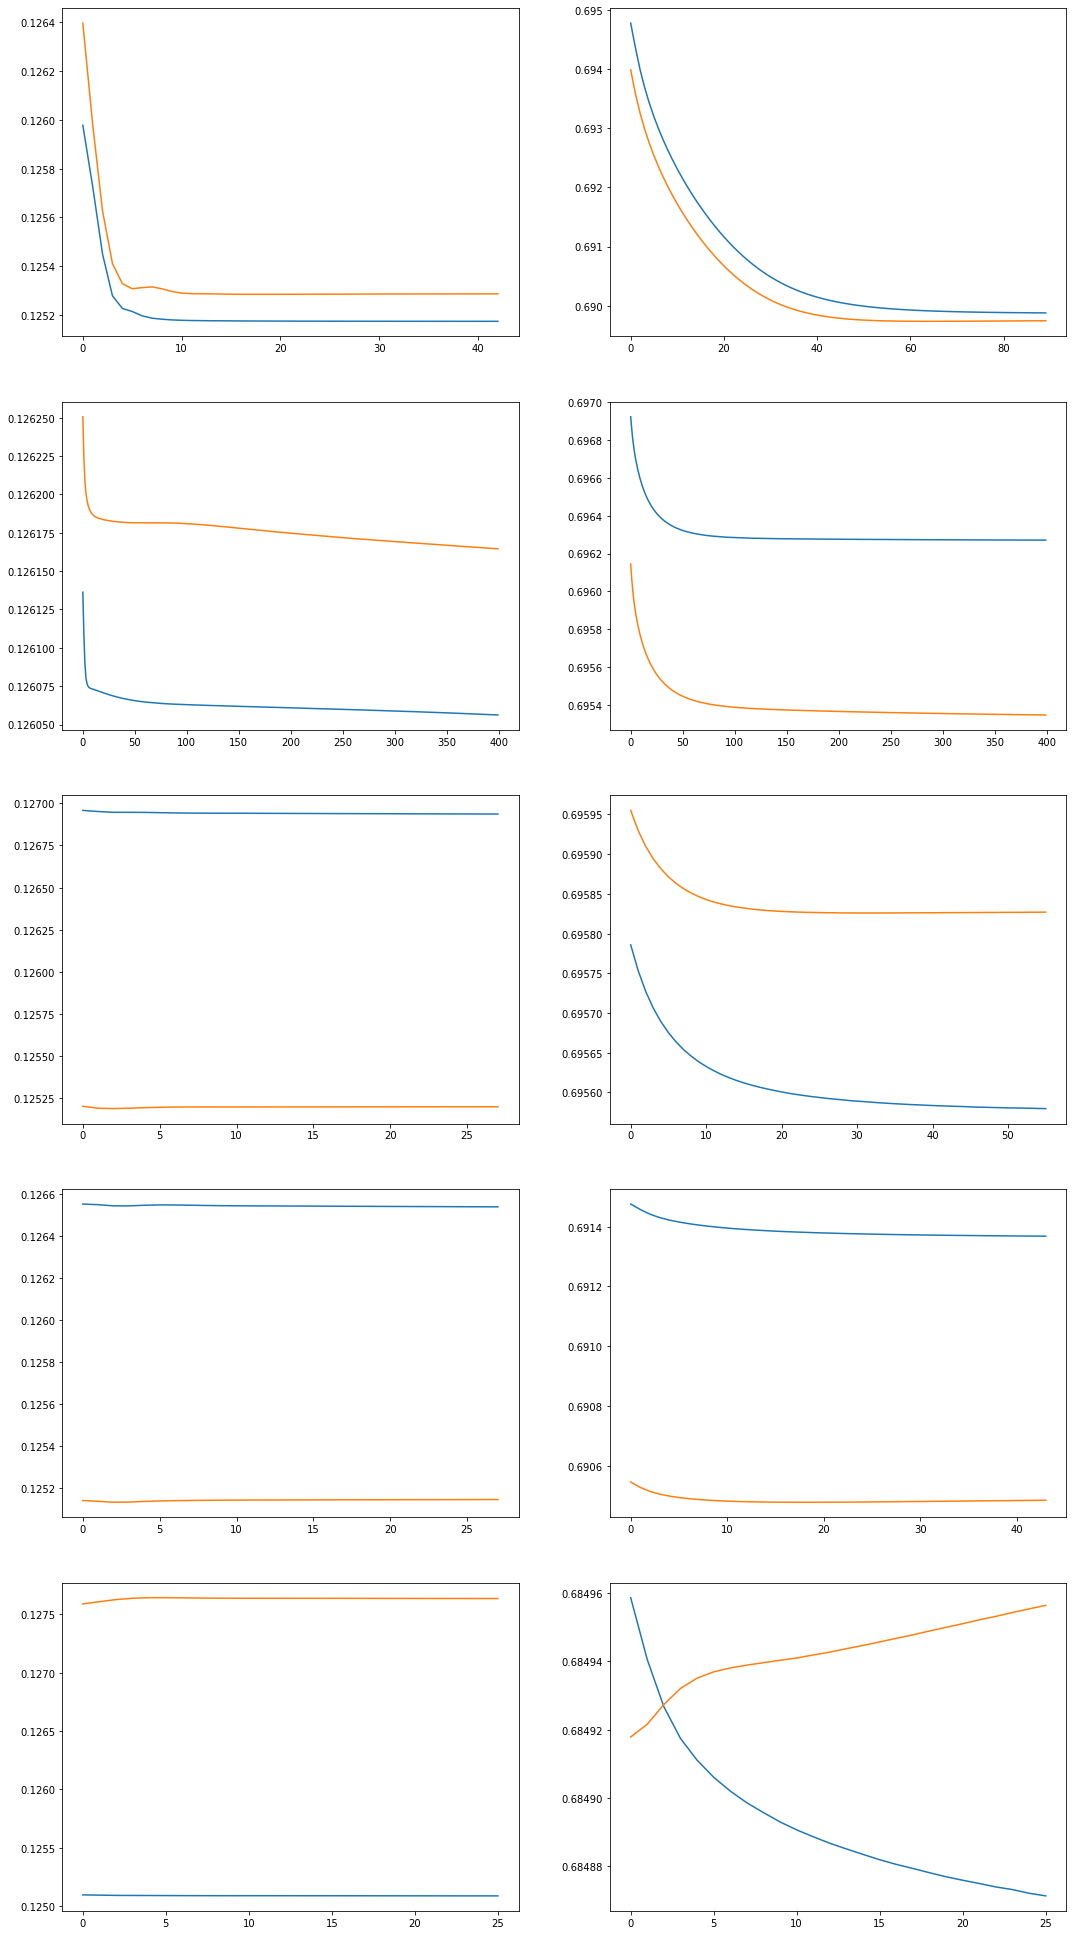

In [28]:
fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

for ofi in range(0,of_niter) :
    
    ax[ofi][0].plot( of_return_dict['mc-hist-step1-iter%d' % ofi].history['loss']  )
    ax[ofi][0].plot( of_return_dict['mc-hist-step1-iter%d' % ofi].history['val_loss']  )

    ax[ofi][1].plot( of_return_dict['mc-hist-step2-iter%d' % ofi].history['loss']  )
    ax[ofi][1].plot( of_return_dict['mc-hist-step2-iter%d' % ofi].history['val_loss']  )
    



<function matplotlib.pyplot.show(close=None, block=None)>

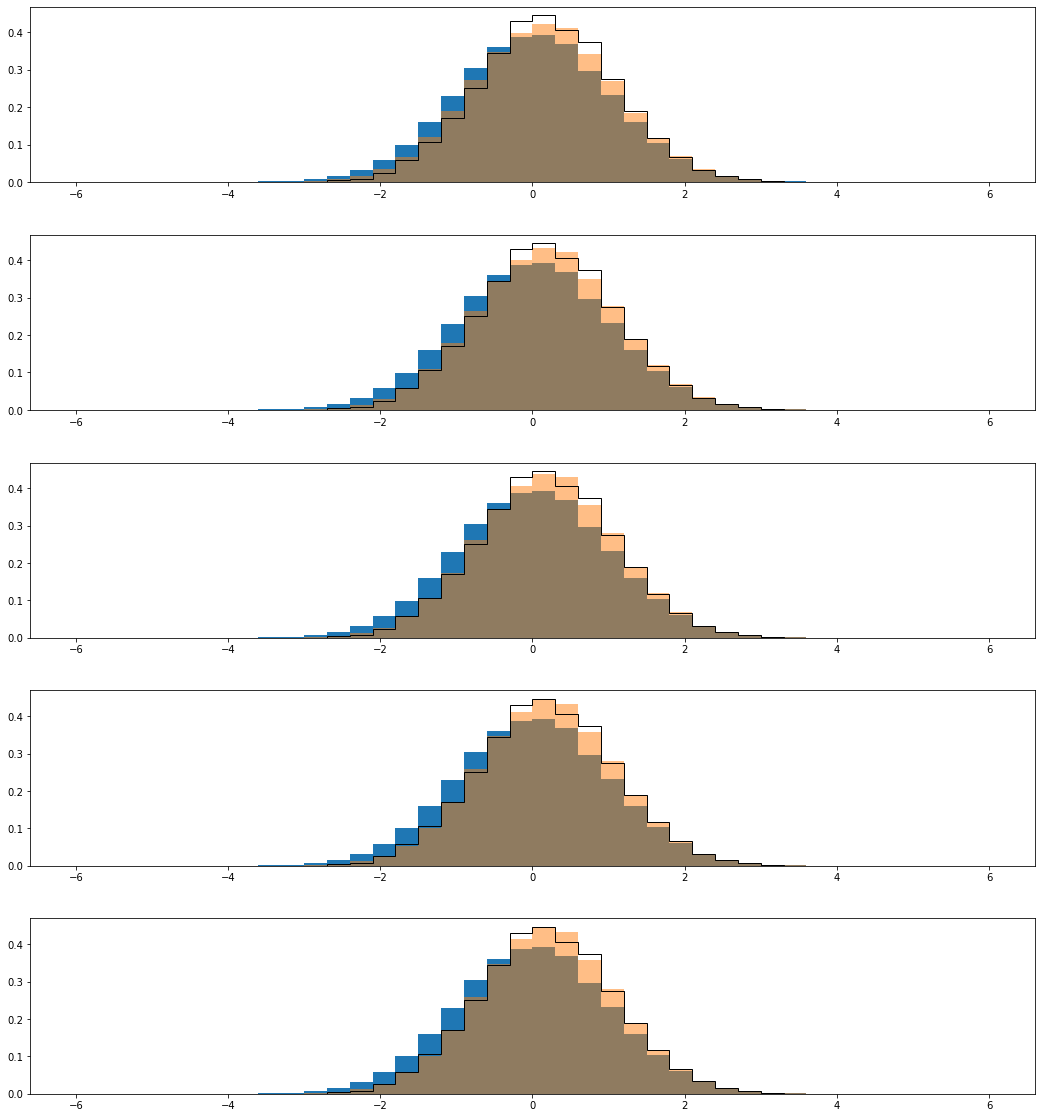

In [29]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim == 1 :
                axi = ax[ofi]
            else :
                axi = ax[ofi][di]
            
            axi.hist( mc_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='mc particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = axi.hist( mc_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            hist_data_truth[ofi,di],_,_ =         axi.hist( true_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )


    else :
        
        for di in range(ndim) :
            
            if ndim == 1 :
                axi = ax[ofi]
            else :
                axi = ax[ofi][di]
        
            hist_data_mc_ofweighted[ofi,di],_,_ = axi.hist( mc_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            hist_data_truth[ofi,di],_,_ =         axi.hist( true_pts[:,di], bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

        

    
   
    



plt.show

In [30]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

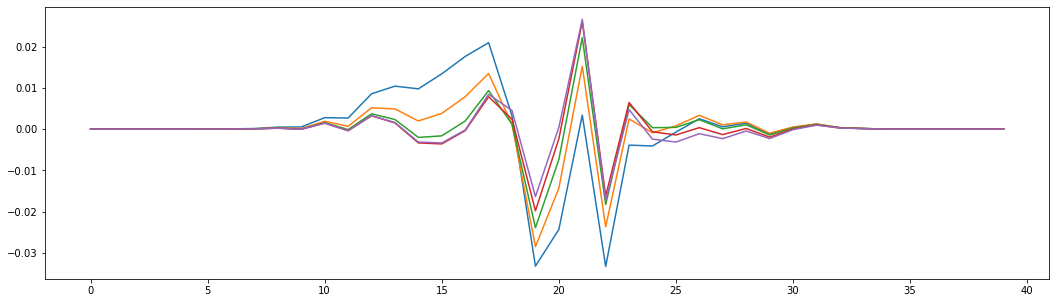

In [31]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim == 1 :
            axi = ax
        else :
            axi = ax[di]
        axi.plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

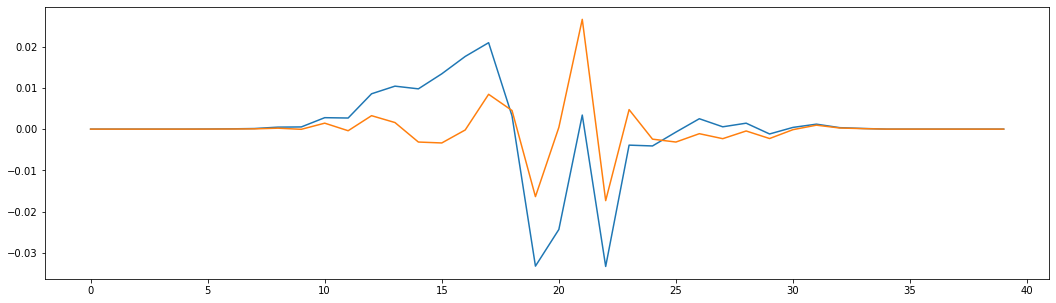

In [32]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim == 1 :
        axi = ax
    else :
        axi = ax[di]
    axi.plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim == 1 :
        axi = ax
    else :
        axi = ax[di]
    axi.plot(hist_data_diff[ofi,di])

    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

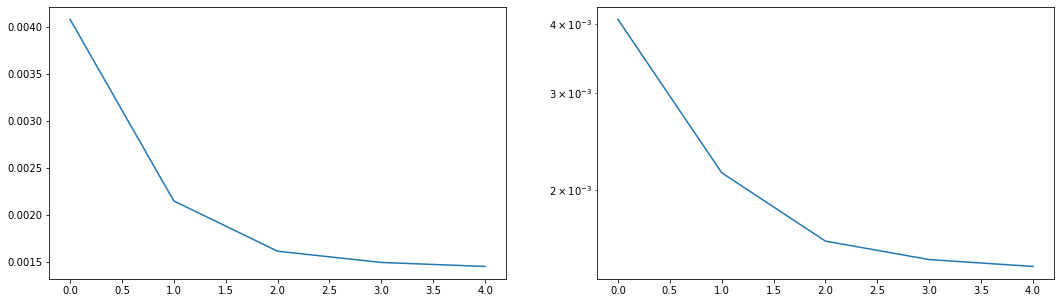

In [33]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

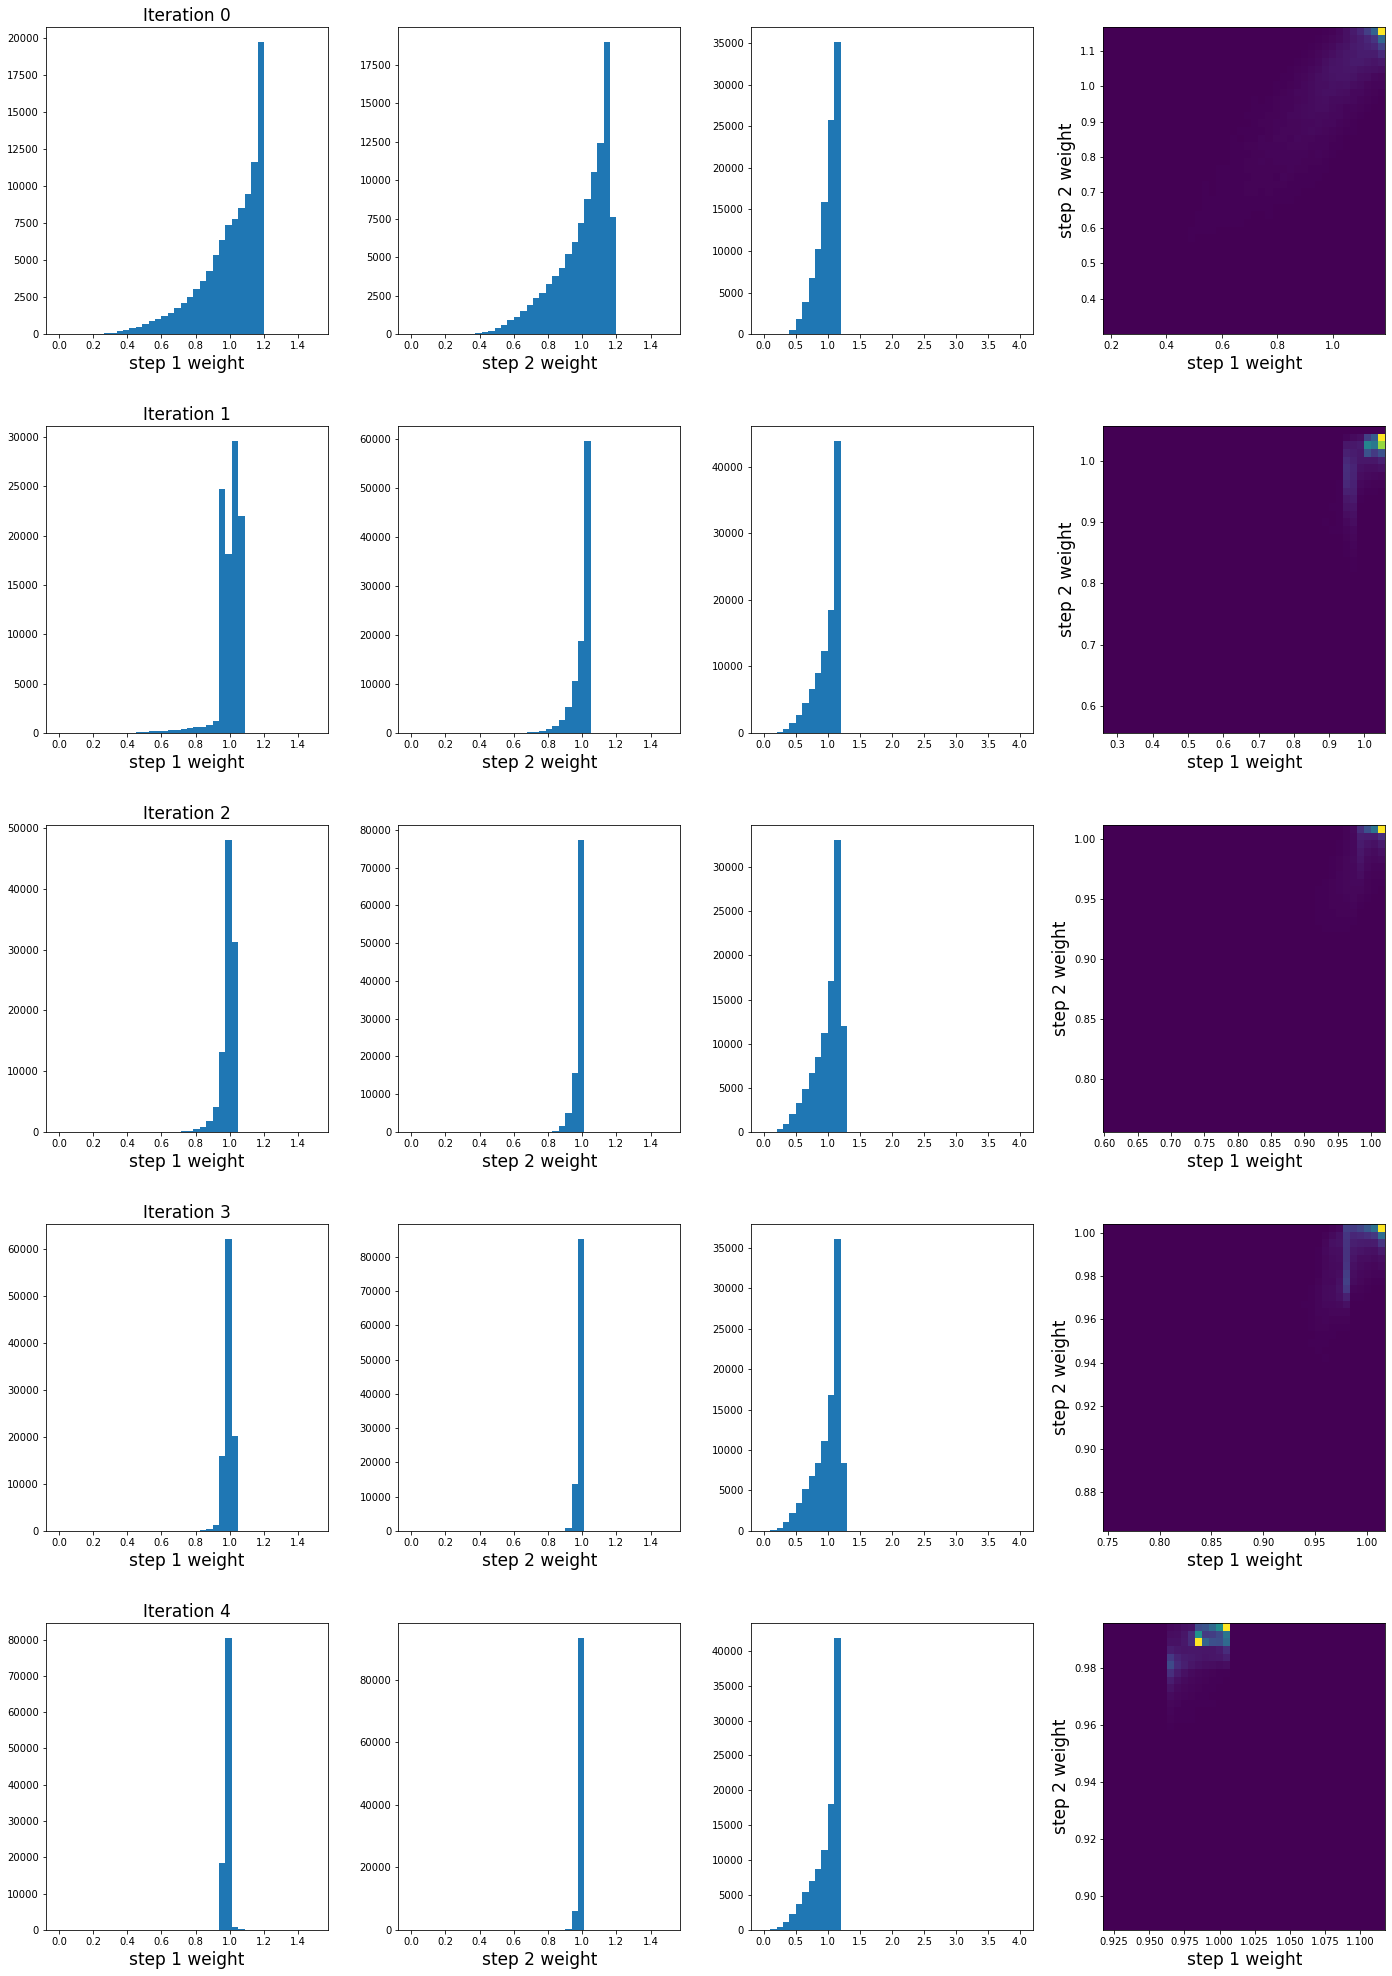

In [34]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,4.] )
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

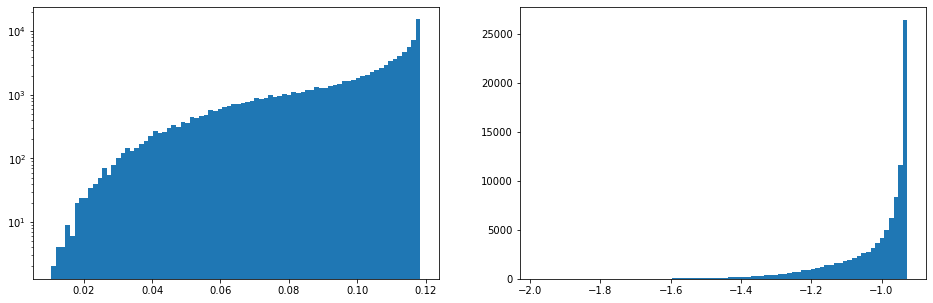

In [35]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

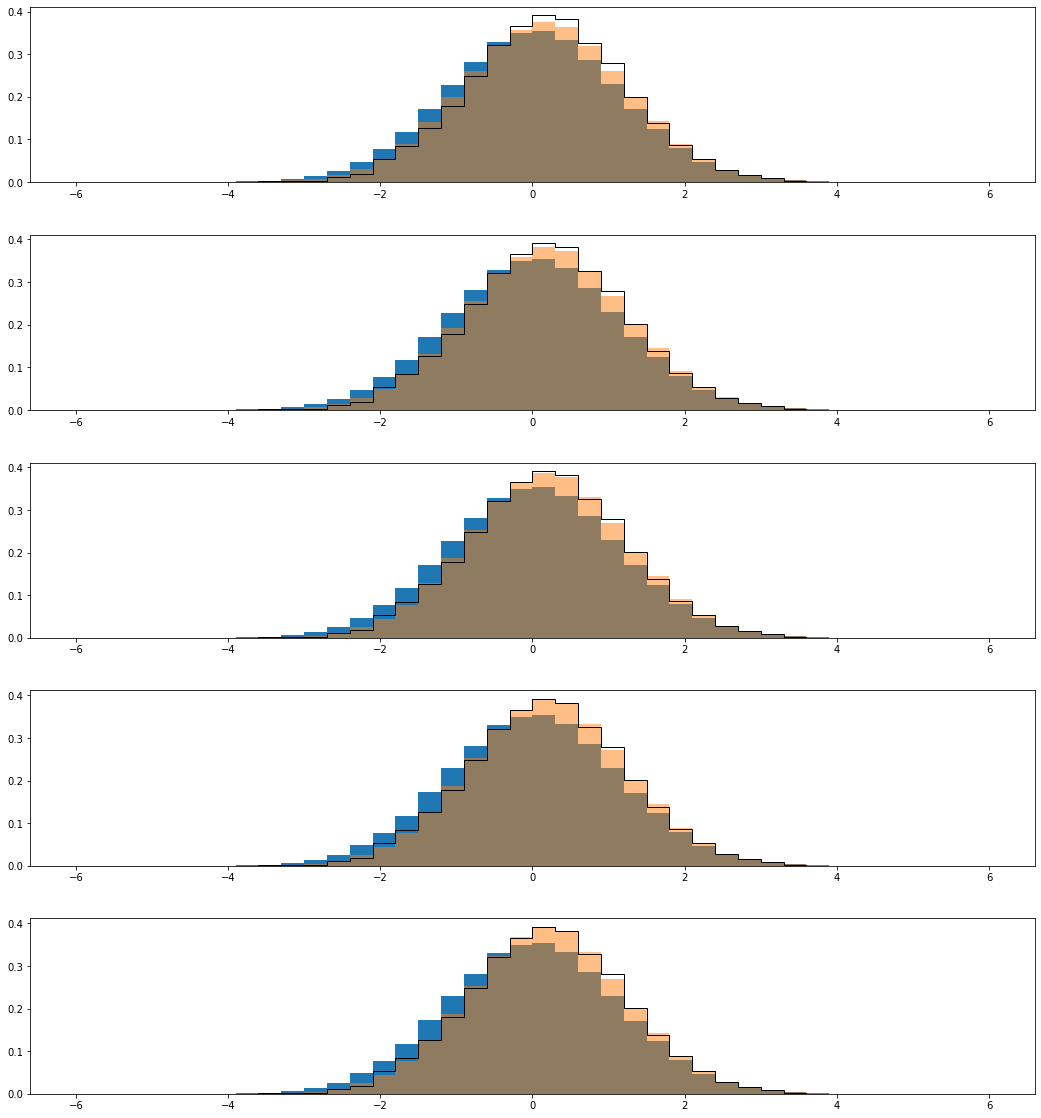

In [36]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim == 1 :
                axi = ax[ofi]
            else :
                axi = ax[ofi][di]
            
            axi.hist( mc_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='mc particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = axi.hist( mc_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         axi.hist( true_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )


    else :
        
        for di in range(ndim) :
            
            if ndim == 1 :
                axi = ax[ofi]
            else :
                axi = ax[ofi][di]

        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = axi.hist( mc_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         axi.hist( true_det_pts[:,di], bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    



plt.show

In [37]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

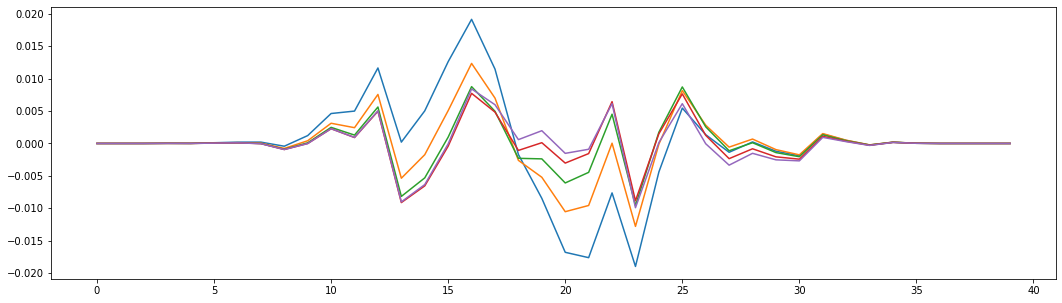

In [38]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim == 1 :
            axi = ax
        else :
            axi = ax[di]
        axi.plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

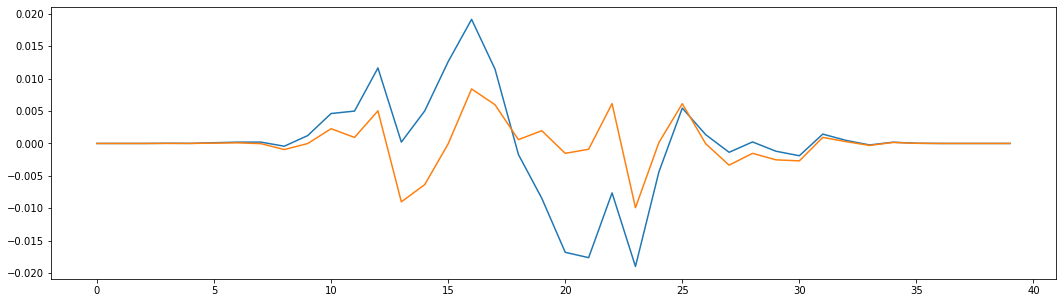

In [39]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim == 1 :
        axi = ax
    else :
        axi = ax[di]
    axi.plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim == 1 :
        axi = ax
    else :
        axi = ax[di]
    axi.plot(det_hist_data_diff[ofi,di])

    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

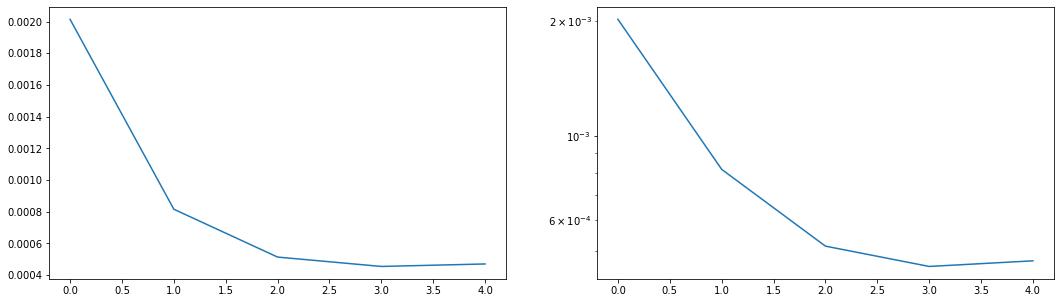

In [40]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [41]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  1.000  rms 0.179      step 2 mean  1.001  rms 0.157
  iter  1 : step 1 mean  0.999  rms 0.071      step 2 mean  0.998  rms 0.052
  iter  2 : step 1 mean  0.990  rms 0.038      step 2 mean  0.990  rms 0.030
  iter  3 : step 1 mean  0.990  rms 0.022      step 2 mean  0.990  rms 0.015
  iter  4 : step 1 mean  0.989  rms 0.014      step 2 mean  0.988  rms 0.008


<function matplotlib.pyplot.show(close=None, block=None)>

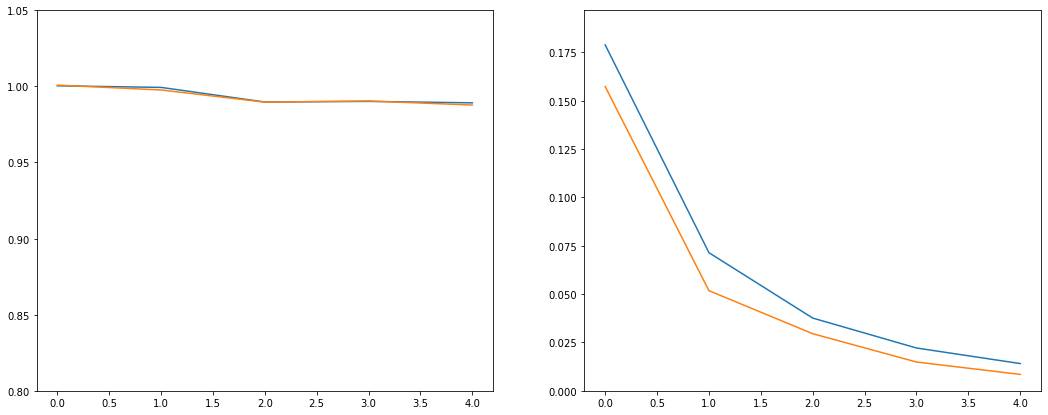

In [42]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

In [43]:

verbose = False



import gc

In [44]:
try:
    os.mkdir( "%s/bootstrap-nn-models" % output_dir )
except :
    print('problem creating bootstrap-nn-models dir')


In [ ]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_boot_samples) :
    
    this_random_seed = random_seed*10000+bi
    
    np.random.seed( this_random_seed )
    keras.utils.set_random_seed( this_random_seed )

    
    if do_bootstrap :
        print("\n\n\n\n ============= Creating bootstrap sample %3d" % bi )
        boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        
    else :
        this_ngen_true = ngen_true
        if use_poisson_fluctuations_around_ngen_true : this_ngen_true = np.random.poisson( ngen_true )
        print("\n\n\n\n ============= Creating toy sample %3d,  this_ngen_true = %d" % (bi, this_ngen_true) )
        boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=this_ngen_true)
        boot_true_det_pts = np.random.normal( boot_true_pts, resolution )
        
    modeldir = "%s/bootstrap-nn-models/bs-%03d" % (output_dir, bi) 
    
    try:
        os.mkdir( modeldir )
    except :
        print('\n\n *** probelm creating model output directory : %s' % modeldir )

        

    #-- Reset the model to ensure fresh random weights for each bootstrap


    model_step1 = Sequential()

    model_step1.add( Dense(units_per_layer, input_dim=ndim, activation='relu', 
                           kernel_regularizer=l2(l2reg_setval), 
                           bias_regularizer=l2(l2reg_setval), 
                           activity_regularizer=l2(al2reg_setval) ) )
    if use_batch_norm : model_step1.add( BatchNormalization() )
    model_step1.add( Dropout(dropout_setval) )

    if number_of_layers > 1 :
        model_step1.add( Dense(units_per_layer, activation='relu', 
                           kernel_regularizer=l2(l2reg_setval), 
                           bias_regularizer=l2(l2reg_setval), 
                           activity_regularizer=l2(al2reg_setval) ) )
        if use_batch_norm : model_step1.add( BatchNormalization() )
        model_step1.add( Dropout(dropout_setval) )

    if number_of_layers > 2 :
        model_step1.add( Dense(units_per_layer, activation='relu', 
                           kernel_regularizer=l2(l2reg_setval), 
                           bias_regularizer=l2(l2reg_setval), 
                           activity_regularizer=l2(al2reg_setval) ) )
        if use_batch_norm : model_step1.add( BatchNormalization() )
        model_step1.add( Dropout(dropout_setval) )

    model_step1.add( Dense(1, activation='sigmoid') )





    model_step2 = Sequential()

    model_step2.add( Dense(units_per_layer, input_dim=ndim, activation='relu', 
                           kernel_regularizer=l2(l2reg_setval), 
                           bias_regularizer=l2(l2reg_setval), 
                           activity_regularizer=l2(al2reg_setval) ) )
    if use_batch_norm : model_step2.add( BatchNormalization() )
    model_step2.add( Dropout(dropout_setval) )

    if number_of_layers > 1 :
        model_step2.add( Dense(units_per_layer, activation='relu', 
                           kernel_regularizer=l2(l2reg_setval), 
                           bias_regularizer=l2(l2reg_setval), 
                           activity_regularizer=l2(al2reg_setval) ) )
        if use_batch_norm : model_step2.add( BatchNormalization() )
        model_step2.add( Dropout(dropout_setval) )

    if number_of_layers > 2 :
        model_step2.add( Dense(units_per_layer, activation='relu', 
                           kernel_regularizer=l2(l2reg_setval), 
                           bias_regularizer=l2(l2reg_setval), 
                           activity_regularizer=l2(al2reg_setval) ) )
        if use_batch_norm : model_step2.add( BatchNormalization() )
        model_step2.add( Dropout(dropout_setval) )

    model_step2.add( Dense(1, activation='sigmoid') )



    opt_step1 = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )
    opt_step2 = tf.keras.optimizers.Adam( learning_rate=(0.04*learning_rate_setval) )  # owen: use lower learning rate in step 2

    model_step1.compile(loss=weighted_binary_crossentropy,
                          optimizer=opt_step1,
                          metrics=['accuracy'])

    model_step2.compile(loss=weighted_binary_crossentropy,
                          optimizer=opt_step2,
                          metrics=['accuracy'])


        
        
    boot_of_return_dict = omnifold( 
        mc_both, boot_true_det_pts, of_niter, model_step1, model_step2, verbose, 
        batch_size_setval, epochs_setval, True, modeldir, patience_setval )



    mc_weight_sf = (1.*len(boot_true_det_pts))/(1.*len(mc_both))



    boot_final_push_weights = boot_of_return_dict["final_push_weights"]
    boot_final_push_weights_scaled = boot_final_push_weights
    boot_final_push_weights_scaled = mc_weight_sf * boot_final_push_weights
    
    print("\n\n bootstrap %d final push weights scaled:" % bi)
    print( boot_final_push_weights_scaled )

     
    with open( '%s/bootstrap-weights-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_final_push_weights_scaled )

    with open( '%s/bootstrap-points-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_true_det_pts )
        
        
    del boot_final_push_weights_scaled
    del boot_of_return_dict
    gc.collect()
    
    





 ============= Creating toy sample   0,  this_ngen_true = 10013
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
    reloading initial model weights


/usr/lib/python3/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-16 22:05:49.305163: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_612', 164 bytes spill stores, 164 bytes spill loads

2025-03-16 22:05:49.572817: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_612', 92 bytes spill stores, 92 bytes spill loads

2025-03-16 22:05:53.582194: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_718', 92 bytes spill stor

Epoch 44: early stopping
Epoch 146: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-000/of-step2-iter00-model
 weights_push at the beginning
[1.13554215 0.91837633 0.94469255 ... 1.09603608 1.12737048 0.87726724]
    reloading initial model weights


/usr/lib/python3/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 29: early stopping
Epoch 37: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-000/of-step2-iter01-model
 weights_push at the beginning
[1.17692823 0.86602867 0.89617978 ... 1.10966903 1.14717154 0.8193079 ]
    reloading initial model weights
Epoch 44: early stopping
Epoch 43: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-000/of-step2-iter02-model
 weights_push at the beginning
[1.14799028 0.8800521  0.91236518 ... 1.1607691  1.18418402 0.83008266]
    reloading initial model weights
Epoch 26: early stopping
Epoch 26: early stopping

 +++ Saving step 2, iteration 3 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-000/of-step2-iter03-model
 weights_push at the beginning
[1.10015213 0.87395822 0.90695094 ... 1.1657694  1.17984345 0.82300946]
    reloading initial model weights
Epoch 28: early stopping


2025-03-16 22:06:30.945555: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 180 bytes spill stores, 180 bytes spill loads

2025-03-16 22:06:31.087941: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 432: early stopping
Epoch 413: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-001/of-step2-iter00-model
 weights_push at the beginning
[1.18235576 0.92412102 0.94840443 ... 1.04882383 1.09978485 0.88588232]
    reloading initial model weights
Epoch 201: early stopping
Epoch 53: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-001/of-step2-iter01-model
 weights_push at the beginning
[1.19912714 0.89647167 0.92743279 ... 1.06329838 1.11781042 0.84824165]
    reloading initial model weights
Epoch 26: early stopping
Epoch 31: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-001/of-step2-iter02-model
 weights_push at the beginning
[1.17855319 0.90567341 0.93926798 ... 1.08182261 1.13336402 0.85353084]
    reloading initial model weights
Epoch 156: early stopp

2025-03-16 22:08:04.525548: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 124 bytes spill stores, 124 bytes spill loads

2025-03-16 22:08:04.747559: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 68: early stopping
Epoch 130: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-002/of-step2-iter00-model
 weights_push at the beginning
[1.1989634  0.88773978 0.90922296 ... 1.07628846 1.11625087 0.85369462]
    reloading initial model weights
Epoch 26: early stopping
Epoch 90: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-002/of-step2-iter01-model
 weights_push at the beginning
[1.21897312 0.87499304 0.90350816 ... 1.11615174 1.15949674 0.83028286]
    reloading initial model weights
Epoch 44: early stopping
Epoch 31: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-002/of-step2-iter02-model
 weights_push at the beginning
[1.16969715 0.87474776 0.90522188 ... 1.12177813 1.15585512 0.82713182]
    reloading initial model weights
Epoch 29: early stopping

2025-03-16 22:09:00.202109: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 260 bytes spill stores, 260 bytes spill loads

2025-03-16 22:09:00.323469: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 65: early stopping
Epoch 499: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-003/of-step2-iter00-model
 weights_push at the beginning
[1.14508498 0.90908909 0.93476391 ... 1.07488668 1.10973072 0.8688702 ]
    reloading initial model weights
Epoch 30: early stopping
Epoch 148: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-003/of-step2-iter01-model
 weights_push at the beginning
[1.18486178 0.86554056 0.89716612 ... 1.08770071 1.12742983 0.81653658]
    reloading initial model weights
Epoch 26: early stopping
Epoch 183: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-003/of-step2-iter02-model
 weights_push at the beginning
[1.17833386 0.86794528 0.90131965 ... 1.11017408 1.15188003 0.81638239]
    reloading initial model weights
Epoch 26: early stoppi

2025-03-16 22:10:12.319334: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 172 bytes spill stores, 172 bytes spill loads

2025-03-16 22:10:12.614653: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 81: early stopping
Epoch 279: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-004/of-step2-iter00-model
 weights_push at the beginning
[1.12901974 0.90565854 0.9301945  ... 1.07872152 1.12221003 0.86677188]
    reloading initial model weights
Epoch 31: early stopping
Epoch 85: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-004/of-step2-iter01-model
 weights_push at the beginning
[1.10754031 0.88036078 0.91503253 ... 1.11643109 1.17146489 0.82643379]
    reloading initial model weights
Epoch 32: early stopping
Epoch 57: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-004/of-step2-iter02-model
 weights_push at the beginning
[1.11686156 0.8733511  0.90897186 ... 1.10315573 1.17899521 0.81735693]
    reloading initial model weights
Epoch 43: early stopping

2025-03-16 22:11:06.101296: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 164 bytes spill stores, 164 bytes spill loads

2025-03-16 22:11:06.295332: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 38: early stopping
Epoch 402: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-005/of-step2-iter00-model
 weights_push at the beginning
[1.11264133 0.90058625 0.92458791 ... 1.07760382 1.13634181 0.86264396]
    reloading initial model weights
Epoch 32: early stopping
Epoch 275: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-005/of-step2-iter01-model
 weights_push at the beginning
[1.13573347 0.88725429 0.91779045 ... 1.12018509 1.18908928 0.83974971]
    reloading initial model weights
Epoch 143: early stopping
Epoch 108: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-005/of-step2-iter02-model
 weights_push at the beginning
[1.10442162 0.87213197 0.90528865 ... 1.11895783 1.17936321 0.82077808]
    reloading initial model weights
Epoch 30: early stopp

2025-03-16 22:12:34.289214: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 232 bytes spill stores, 232 bytes spill loads

2025-03-16 22:12:34.447205: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 170: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-006/of-step2-iter00-model
 weights_push at the beginning
[1.11297286 0.92490876 0.95155156 ... 1.08554542 1.13407087 0.88314927]
    reloading initial model weights
Epoch 27: early stopping
Epoch 45: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-006/of-step2-iter01-model
 weights_push at the beginning
[1.1220774  0.89939319 0.93252707 ... 1.10902789 1.16592463 0.84738079]
    reloading initial model weights
Epoch 104: early stopping
Epoch 37: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-006/of-step2-iter02-model
 weights_push at the beginning
[1.08774964 0.91057679 0.94603028 ... 1.12648033 1.17982756 0.85501949]
    reloading initial model weights
Epoch 26: early stopping
Epoch 137: early stoppi

2025-03-16 22:14:02.089647: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 164 bytes spill stores, 164 bytes spill loads

2025-03-16 22:14:02.183933: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 150: early stopping
Epoch 470: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-007/of-step2-iter00-model
 weights_push at the beginning
[1.12739885 0.91910267 0.94003373 ... 1.04590118 1.08717453 0.88419378]
    reloading initial model weights
Epoch 32: early stopping
Epoch 92: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-007/of-step2-iter01-model
 weights_push at the beginning
[1.15286764 0.90460145 0.93295626 ... 1.08738771 1.12597846 0.85881784]
    reloading initial model weights
Epoch 175: early stopping
Epoch 34: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-007/of-step2-iter02-model
 weights_push at the beginning
[1.1740262  0.90857491 0.93639765 ... 1.09946593 1.13940963 0.8635711 ]
    reloading initial model weights
Epoch 33: early stoppi

2025-03-16 22:16:08.500015: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 140 bytes spill stores, 140 bytes spill loads

2025-03-16 22:16:08.780960: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 75: early stopping
Epoch 328: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-009/of-step2-iter00-model
 weights_push at the beginning
[1.16769814 0.93639362 0.95685703 ... 1.04878855 1.09969163 0.90177029]
    reloading initial model weights
Epoch 33: early stopping
Epoch 42: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-009/of-step2-iter01-model
 weights_push at the beginning
[1.14712153 0.91542809 0.9424889  ... 1.06865845 1.12059068 0.87081686]
    reloading initial model weights
Epoch 26: early stopping
Epoch 37: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-009/of-step2-iter02-model
 weights_push at the beginning
[1.18036185 0.8996004  0.92860387 ... 1.0752423  1.13516051 0.85216038]
    reloading initial model weights
Epoch 29: early stopping

2025-03-16 22:16:57.433944: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 140 bytes spill stores, 140 bytes spill loads

2025-03-16 22:16:57.555014: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 29: early stopping
Epoch 179: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-010/of-step2-iter00-model
 weights_push at the beginning
[1.17394531 0.9045254  0.93043369 ... 1.06881213 1.10888851 0.8633666 ]
    reloading initial model weights
Epoch 40: early stopping
Epoch 38: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-010/of-step2-iter01-model
 weights_push at the beginning
[1.19077372 0.88324401 0.91577316 ... 1.08445378 1.13644572 0.83160081]
    reloading initial model weights
Epoch 26: early stopping
Epoch 38: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-010/of-step2-iter02-model
 weights_push at the beginning
[1.18033001 0.89928245 0.93415596 ... 1.1052463  1.16668046 0.84412488]
    reloading initial model weights
Epoch 26: early stopping

2025-03-16 22:17:50.450377: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 92 bytes spill stores, 92 bytes spill loads

2025-03-16 22:17:50.662788: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 62: early stopping
Epoch 507: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-011/of-step2-iter00-model
 weights_push at the beginning
[1.11106157 0.91692066 0.93841296 ... 1.07638526 1.11246789 0.8815915 ]
    reloading initial model weights
Epoch 27: early stopping
Epoch 150: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-011/of-step2-iter01-model
 weights_push at the beginning
[1.1328204  0.88645657 0.9141089  ... 1.10479872 1.1538941  0.8418504 ]
    reloading initial model weights
Epoch 26: early stopping
Epoch 142: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-011/of-step2-iter02-model
 weights_push at the beginning
[1.18149277 0.89227413 0.92359847 ... 1.14138758 1.19541312 0.84219492]
    reloading initial model weights
Epoch 26: early stoppi

2025-03-16 22:18:59.789533: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 124 bytes spill stores, 124 bytes spill loads

2025-03-16 22:19:00.075084: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 161: early stopping
Epoch 243: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-012/of-step2-iter00-model
 weights_push at the beginning
[1.18176603 0.92109936 0.94464242 ... 1.06216073 1.10431612 0.88423622]
    reloading initial model weights
Epoch 154: early stopping
Epoch 95: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-012/of-step2-iter01-model
 weights_push at the beginning
[1.17345349 0.89736016 0.9274781  ... 1.10705567 1.15016416 0.85153903]
    reloading initial model weights
Epoch 28: early stopping
Epoch 161: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-012/of-step2-iter02-model
 weights_push at the beginning
[1.14895473 0.88528042 0.91508233 ... 1.10281095 1.14621093 0.83995953]
    reloading initial model weights
Epoch 31: early stopp

2025-03-16 22:20:10.365106: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 92 bytes spill stores, 92 bytes spill loads

2025-03-16 22:20:10.713103: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 82: early stopping
Epoch 394: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-013/of-step2-iter00-model
 weights_push at the beginning
[1.14553046 0.91844845 0.9381119  ... 1.0469166  1.09673417 0.88627136]
    reloading initial model weights
Epoch 29: early stopping
Epoch 41: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-013/of-step2-iter01-model
 weights_push at the beginning
[1.1708883  0.90133012 0.92611404 ... 1.06404545 1.11926658 0.86130394]
    reloading initial model weights
Epoch 268: early stopping
Epoch 26: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-013/of-step2-iter02-model
 weights_push at the beginning
[1.20561474 0.90122396 0.92997136 ... 1.08467589 1.1450943  0.85479314]
    reloading initial model weights
Epoch 26: early stoppin

2025-03-16 22:21:13.648688: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 92 bytes spill stores, 92 bytes spill loads

2025-03-16 22:21:13.795207: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 185: early stopping
Epoch 295: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-014/of-step2-iter00-model
 weights_push at the beginning
[1.19597983 0.9008196  0.92600173 ... 1.06636572 1.11413062 0.86099041]
    reloading initial model weights
Epoch 135: early stopping
Epoch 76: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-014/of-step2-iter01-model
 weights_push at the beginning
[1.22466502 0.89465381 0.92457353 ... 1.10825364 1.15450802 0.84767681]
    reloading initial model weights
Epoch 28: early stopping
Epoch 134: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-014/of-step2-iter02-model
 weights_push at the beginning
[1.20122682 0.88837111 0.92281649 ... 1.12369712 1.16749846 0.8347721 ]
    reloading initial model weights
Epoch 26: early stopp

2025-03-16 22:22:24.672130: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 92 bytes spill stores, 92 bytes spill loads

2025-03-16 22:22:24.835597: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 82: early stopping
Epoch 371: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-015/of-step2-iter00-model
 weights_push at the beginning
[1.18709004 0.8869307  0.91044235 ... 1.06446588 1.11121643 0.85002333]
    reloading initial model weights
Epoch 49: early stopping
Epoch 161: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-015/of-step2-iter01-model
 weights_push at the beginning
[1.22573418 0.8806223  0.91120046 ... 1.10406639 1.15752064 0.83308788]
    reloading initial model weights
Epoch 26: early stopping
Epoch 100: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-015/of-step2-iter02-model
 weights_push at the beginning
[1.14604232 0.86592974 0.89938194 ... 1.11648901 1.15497236 0.81421283]
    reloading initial model weights
Epoch 26: early stoppi

2025-03-16 22:23:38.756516: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 216 bytes spill stores, 216 bytes spill loads

2025-03-16 22:23:39.063779: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 40: early stopping
Epoch 141: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-016/of-step2-iter00-model
 weights_push at the beginning
[1.16573179 0.9122085  0.93476737 ... 1.08312631 1.10268068 0.8766914 ]
    reloading initial model weights
Epoch 43: early stopping
Epoch 40: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-016/of-step2-iter01-model
 weights_push at the beginning
[1.20795996 0.87728164 0.90567863 ... 1.11321962 1.14295795 0.83294231]
    reloading initial model weights
Epoch 26: early stopping
Epoch 60: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-016/of-step2-iter02-model
 weights_push at the beginning
[1.19210267 0.88232533 0.91656585 ... 1.15577675 1.18927927 0.82963402]
    reloading initial model weights
Epoch 26: early stopping

2025-03-16 22:24:22.080221: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 172 bytes spill stores, 172 bytes spill loads

2025-03-16 22:24:22.299295: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 189: early stopping
Epoch 370: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-017/of-step2-iter00-model
 weights_push at the beginning
[1.15371692 0.90736228 0.92962307 ... 1.06783676 1.12209082 0.87208188]
    reloading initial model weights
Epoch 35: early stopping
Epoch 102: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-017/of-step2-iter01-model
 weights_push at the beginning
[1.1938937  0.88540647 0.91111368 ... 1.09623486 1.15801117 0.84494139]
    reloading initial model weights
Epoch 26: early stopping
Epoch 100: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-017/of-step2-iter02-model
 weights_push at the beginning
[1.16259291 0.86695287 0.89493612 ... 1.11922511 1.17522133 0.82306828]
    reloading initial model weights
Epoch 26: early stopp

2025-03-16 22:25:32.534494: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 152 bytes spill stores, 152 bytes spill loads

2025-03-16 22:25:32.834961: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 44: early stopping
Epoch 214: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-018/of-step2-iter00-model
 weights_push at the beginning
[1.17691016 0.91204238 0.93541837 ... 1.07855928 1.12395632 0.87526649]
    reloading initial model weights
Epoch 28: early stopping
Epoch 159: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-018/of-step2-iter01-model
 weights_push at the beginning
[1.15334701 0.8959744  0.92702575 ... 1.11908229 1.17755784 0.84772885]
    reloading initial model weights
Epoch 28: early stopping
Epoch 78: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-018/of-step2-iter02-model
 weights_push at the beginning
[1.15235963 0.86478136 0.89585771 ... 1.10268569 1.16791549 0.8165705 ]
    reloading initial model weights
Epoch 26: early stoppin

2025-03-16 22:26:27.534730: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 116 bytes spill stores, 116 bytes spill loads

2025-03-16 22:26:27.780742: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 33: early stopping
Epoch 165: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-019/of-step2-iter00-model
 weights_push at the beginning
[1.13309109 0.90286136 0.92688733 ... 1.10210562 1.11768806 0.86516428]
    reloading initial model weights
Epoch 125: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-019/of-step2-iter01-model
 weights_push at the beginning
[1.1198921  0.88557224 0.91479519 ... 1.12282641 1.14367029 0.8389255 ]
    reloading initial model weights
Epoch 27: early stopping
Epoch 138: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-019/of-step2-iter02-model
 weights_push at the beginning
[1.13112386 0.87670956 0.91021168 ... 1.14473185 1.16007016 0.82374928]
    reloading initial model weights
Epoch 47: early stopping
Epoch 138: early stopp

2025-03-16 22:27:43.405722: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 168 bytes spill stores, 168 bytes spill loads

2025-03-16 22:27:43.577320: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 49: early stopping
Epoch 132: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-020/of-step2-iter00-model
 weights_push at the beginning
[1.18542433 0.90721881 0.93327105 ... 1.11476088 1.11956537 0.86645657]
    reloading initial model weights
Epoch 29: early stopping
Epoch 106: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-020/of-step2-iter01-model
 weights_push at the beginning
[1.18643995 0.86552952 0.89775553 ... 1.13909447 1.14705906 0.81606464]
    reloading initial model weights
Epoch 57: early stopping
Epoch 124: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-020/of-step2-iter02-model
 weights_push at the beginning
[1.1807769  0.87392758 0.90744798 ... 1.15978869 1.15593377 0.8225489 ]
    reloading initial model weights
Epoch 219: early stopp

2025-03-16 22:28:48.579027: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 180 bytes spill stores, 180 bytes spill loads

2025-03-16 22:28:48.816452: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 35: early stopping
Epoch 141: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-021/of-step2-iter00-model
 weights_push at the beginning
[1.13706946 0.92923766 0.95616782 ... 1.09747791 1.13555622 0.88739371]
    reloading initial model weights
Epoch 47: early stopping
Epoch 197: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-021/of-step2-iter01-model
 weights_push at the beginning
[1.18809101 0.88806034 0.92133189 ... 1.10911507 1.15544867 0.83684201]
    reloading initial model weights
Epoch 29: early stopping
Epoch 80: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-021/of-step2-iter02-model
 weights_push at the beginning
[1.1790785  0.88163936 0.91702996 ... 1.12968695 1.17653174 0.8272943 ]
    reloading initial model weights
Epoch 26: early stoppin

2025-03-16 22:29:37.172115: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 172 bytes spill stores, 172 bytes spill loads

2025-03-16 22:29:37.449708: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 51: early stopping
Epoch 316: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-022/of-step2-iter00-model
 weights_push at the beginning
[1.12452602 0.94912952 0.97333419 ... 1.09098518 1.1354233  0.91060781]
    reloading initial model weights
Epoch 29: early stopping
Epoch 30: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-022/of-step2-iter01-model
 weights_push at the beginning
[1.17635624 0.91410779 0.94175644 ... 1.098547   1.15306806 0.87068737]
    reloading initial model weights
Epoch 28: early stopping
Epoch 31: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-022/of-step2-iter02-model
 weights_push at the beginning
[1.14610982 0.88912301 0.92059276 ... 1.11146866 1.16082651 0.8400741 ]
    reloading initial model weights
Epoch 26: early stopping

2025-03-16 22:30:24.063941: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 168 bytes spill stores, 168 bytes spill loads

2025-03-16 22:30:24.228262: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 97: early stopping
Epoch 125: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-023/of-step2-iter00-model
 weights_push at the beginning
[1.18620658 0.90166038 0.92775136 ... 1.07413352 1.12393165 0.86062807]
    reloading initial model weights
Epoch 30: early stopping
Epoch 60: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-023/of-step2-iter01-model
 weights_push at the beginning
[1.19083794 0.88090811 0.91311982 ... 1.12671256 1.17654841 0.8307762 ]
    reloading initial model weights
Epoch 27: early stopping
Epoch 139: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-023/of-step2-iter02-model
 weights_push at the beginning
[1.20177956 0.87578329 0.90875098 ... 1.13376354 1.18455869 0.82451037]
    reloading initial model weights
Epoch 26: early stoppin

2025-03-16 22:31:12.348599: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads

2025-03-16 22:31:12.421632: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 152 bytes spill stores, 152 bytes spill loads



Epoch 91: early stopping
Epoch 585: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-024/of-step2-iter00-model
 weights_push at the beginning
[1.16815925 0.90778255 0.92881179 ... 1.07766402 1.11980927 0.87222141]
    reloading initial model weights
Epoch 287: early stopping
Epoch 89: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-024/of-step2-iter01-model
 weights_push at the beginning
[1.16541905 0.88428954 0.91138598 ... 1.11334974 1.16012509 0.83975161]
    reloading initial model weights
Epoch 34: early stopping
Epoch 123: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-024/of-step2-iter02-model
 weights_push at the beginning
[1.15645967 0.87012949 0.90032879 ... 1.12428348 1.16805743 0.82098065]
    reloading initial model weights
Epoch 110: early stopp

2025-03-16 22:32:43.412972: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 92 bytes spill stores, 92 bytes spill loads

2025-03-16 22:32:43.757750: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 485: early stopping
Epoch 484: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-025/of-step2-iter00-model
 weights_push at the beginning
[1.1775403  0.90987879 0.93327171 ... 1.05167103 1.10913157 0.87080956]
    reloading initial model weights
Epoch 137: early stopping
Epoch 49: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-025/of-step2-iter01-model
 weights_push at the beginning
[1.19829189 0.88672867 0.91691238 ... 1.08226206 1.14210469 0.83762704]
    reloading initial model weights
Epoch 36: early stopping
Epoch 27: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-025/of-step2-iter02-model
 weights_push at the beginning
[1.1979777  0.87011408 0.90115264 ... 1.07408711 1.13495017 0.81988422]
    reloading initial model weights
Epoch 195: early stopp

2025-03-16 22:34:42.507225: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 96 bytes spill stores, 96 bytes spill loads

2025-03-16 22:34:42.845407: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 83: early stopping
Epoch 201: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-026/of-step2-iter00-model
 weights_push at the beginning
[1.20695543 0.90273231 0.92386109 ... 1.04422021 1.08766639 0.86797231]
    reloading initial model weights
Epoch 65: early stopping
Epoch 234: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-026/of-step2-iter01-model
 weights_push at the beginning
[1.14042763 0.89373841 0.92088965 ... 1.07291937 1.13993179 0.84780987]
    reloading initial model weights
Epoch 42: early stopping
Epoch 36: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-026/of-step2-iter02-model
 weights_push at the beginning
[1.11942668 0.89092437 0.91993221 ... 1.0980122  1.16287948 0.84226863]
    reloading initial model weights
Epoch 208: early stoppi

2025-03-16 22:35:52.235947: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 160 bytes spill stores, 160 bytes spill loads

2025-03-16 22:35:52.540046: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 40: early stopping
Epoch 186: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-027/of-step2-iter00-model
 weights_push at the beginning
[1.12929046 0.92408937 0.94752914 ... 1.081985   1.11918569 0.88725108]
    reloading initial model weights
Epoch 30: early stopping
Epoch 97: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-027/of-step2-iter01-model
 weights_push at the beginning
[1.14415918 0.90012885 0.93016072 ... 1.09855643 1.13863166 0.85334797]
    reloading initial model weights
Epoch 64: early stopping
Epoch 150: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-027/of-step2-iter02-model
 weights_push at the beginning
[1.14435286 0.89720976 0.9293521  ... 1.10929827 1.1480065  0.84728773]
    reloading initial model weights
Epoch 29: early stoppin

2025-03-16 22:36:44.069633: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 172 bytes spill stores, 172 bytes spill loads

2025-03-16 22:36:44.307186: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 40: early stopping
Epoch 90: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-028/of-step2-iter00-model
 weights_push at the beginning
[1.1685003  0.9188475  0.94391131 ... 1.09850478 1.13018715 0.87954271]
    reloading initial model weights
Epoch 26: early stopping
Epoch 108: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-028/of-step2-iter01-model
 weights_push at the beginning
[1.17677588 0.85889146 0.89067916 ... 1.11270875 1.14440535 0.80952085]
    reloading initial model weights
Epoch 26: early stopping
Epoch 43: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-028/of-step2-iter02-model
 weights_push at the beginning
[1.15881361 0.88147556 0.91522935 ... 1.14471127 1.17026216 0.82910187]
    reloading initial model weights
Epoch 26: early stopping

2025-03-16 22:37:20.561534: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 96 bytes spill stores, 96 bytes spill loads

2025-03-16 22:37:20.733536: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 96: early stopping
Epoch 627: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-029/of-step2-iter00-model
 weights_push at the beginning
[1.14461744 0.90992749 0.93961865 ... 1.08724952 1.12658119 0.86395741]
    reloading initial model weights
Epoch 26: early stopping
Epoch 98: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-029/of-step2-iter01-model
 weights_push at the beginning
[1.19485497 0.89618199 0.93603669 ... 1.14195541 1.1980618  0.83555161]
    reloading initial model weights
Epoch 27: early stopping
Epoch 52: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-029/of-step2-iter02-model
 weights_push at the beginning
[1.17894246 0.8781619  0.92003333 ... 1.1371486  1.18954416 0.81422996]
    reloading initial model weights
Epoch 65: early stopping

2025-03-16 22:41:33.689147: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 92 bytes spill stores, 92 bytes spill loads

2025-03-16 22:41:33.807466: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 35: early stopping
Epoch 234: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-032/of-step2-iter00-model
 weights_push at the beginning
[1.17275774 0.91673243 0.94187057 ... 1.07510018 1.10824263 0.8772139 ]
    reloading initial model weights
Epoch 306: early stopping
Epoch 59: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-032/of-step2-iter01-model
 weights_push at the beginning
[1.15508475 0.89550699 0.92603593 ... 1.09399023 1.12648543 0.84795798]
    reloading initial model weights
Epoch 83: early stopping
Epoch 61: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-032/of-step2-iter02-model
 weights_push at the beginning
[1.14512824 0.89767887 0.93011768 ... 1.10330047 1.13212403 0.84743416]
    reloading initial model weights
Epoch 29: early stoppin

2025-03-16 22:42:41.353939: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 128 bytes spill stores, 128 bytes spill loads

2025-03-16 22:42:41.525879: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 35: early stopping
Epoch 217: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-033/of-step2-iter00-model
 weights_push at the beginning
[1.09648037 0.92956901 0.95906025 ... 1.10041106 1.15053332 0.88349116]
    reloading initial model weights
Epoch 395: early stopping
Epoch 65: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-033/of-step2-iter01-model
 weights_push at the beginning
[1.11601847 0.89491111 0.93008731 ... 1.11103382 1.16883779 0.8404025 ]
    reloading initial model weights
Epoch 360: early stopping
Epoch 155: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-033/of-step2-iter02-model
 weights_push at the beginning
[1.13306127 0.88776775 0.92658959 ... 1.15147395 1.2203436  0.82793102]
    reloading initial model weights
Epoch 30: early stopp

2025-03-16 22:44:02.735472: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 216 bytes spill stores, 216 bytes spill loads

2025-03-16 22:44:02.958173: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 54: early stopping
Epoch 94: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-034/of-step2-iter00-model
 weights_push at the beginning
[1.20898604 0.89260489 0.91528451 ... 1.08368874 1.12198937 0.85701036]
    reloading initial model weights
Epoch 27: early stopping
Epoch 125: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-034/of-step2-iter01-model
 weights_push at the beginning
[1.18411751 0.87360686 0.90337779 ... 1.1071614  1.16344928 0.82751446]
    reloading initial model weights
Epoch 26: early stopping
Epoch 28: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-034/of-step2-iter02-model
 weights_push at the beginning
[1.15942097 0.85284968 0.88556354 ... 1.11043183 1.16198529 0.80246457]
    reloading initial model weights
Epoch 26: early stopping

2025-03-16 22:46:26.524583: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 100 bytes spill stores, 100 bytes spill loads

2025-03-16 22:46:26.787895: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 85: early stopping
Epoch 556: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-036/of-step2-iter00-model
 weights_push at the beginning
[1.11161709 0.91391873 0.93367475 ... 1.06359386 1.09474325 0.87598068]
    reloading initial model weights
Epoch 44: early stopping
Epoch 86: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-036/of-step2-iter01-model
 weights_push at the beginning
[1.16900288 0.89399478 0.91990522 ... 1.11139481 1.14791784 0.84698127]
    reloading initial model weights
Epoch 314: early stopping
Epoch 56: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-036/of-step2-iter02-model
 weights_push at the beginning
[1.1361743  0.89387051 0.92148171 ... 1.13122915 1.15903397 0.84435994]
    reloading initial model weights
Epoch 26: early stoppin

2025-03-16 22:47:44.997649: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 124 bytes spill stores, 124 bytes spill loads

2025-03-16 22:47:45.218930: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 30: early stopping
Epoch 402: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-037/of-step2-iter00-model
 weights_push at the beginning
[1.16098928 0.92394018 0.94150901 ... 1.05530727 1.09701443 0.89244992]
    reloading initial model weights
Epoch 27: early stopping
Epoch 111: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-037/of-step2-iter01-model
 weights_push at the beginning
[1.17974341 0.92735933 0.95229551 ... 1.09197037 1.12527855 0.88458989]
    reloading initial model weights
Epoch 32: early stopping
Epoch 32: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-037/of-step2-iter02-model
 weights_push at the beginning
[1.16163887 0.91906942 0.94371264 ... 1.09434968 1.12406542 0.87677648]
    reloading initial model weights
Epoch 26: early stoppin

2025-03-16 22:50:05.838944: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 172 bytes spill stores, 172 bytes spill loads

2025-03-16 22:50:06.008755: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 164: early stopping
Epoch 98: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-039/of-step2-iter00-model
 weights_push at the beginning
[1.12679279 0.90399569 0.92978597 ... 1.08378041 1.13336611 0.86330867]
    reloading initial model weights
Epoch 117: early stopping
Epoch 93: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-039/of-step2-iter01-model
 weights_push at the beginning
[1.13754598 0.86922709 0.90088544 ... 1.11418582 1.16876502 0.81980762]
    reloading initial model weights
Epoch 32: early stopping
Epoch 26: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-039/of-step2-iter02-model
 weights_push at the beginning
[1.1622275  0.86368663 0.89868918 ... 1.13127553 1.18825933 0.80924755]
    reloading initial model weights
Epoch 30: early stoppin

2025-03-16 22:51:06.152333: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 180 bytes spill stores, 180 bytes spill loads

2025-03-16 22:51:06.371778: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 32: early stopping
Epoch 423: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-040/of-step2-iter00-model
 weights_push at the beginning
[1.15396917 0.93549687 0.96207255 ... 1.12037563 1.15939045 0.8919732 ]
    reloading initial model weights
Epoch 28: early stopping
Epoch 62: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-040/of-step2-iter01-model
 weights_push at the beginning
[1.15353536 0.90293651 0.93537806 ... 1.14660919 1.18665751 0.85085476]
    reloading initial model weights
Epoch 29: early stopping
Epoch 26: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-040/of-step2-iter02-model
 weights_push at the beginning
[1.13880341 0.89281527 0.92739592 ... 1.15959646 1.19544971 0.8377056 ]
    reloading initial model weights
Epoch 26: early stopping

2025-03-16 22:54:38.004554: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 152 bytes spill stores, 152 bytes spill loads

2025-03-16 22:54:38.237401: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 53: early stopping
Epoch 168: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-043/of-step2-iter00-model
 weights_push at the beginning
[1.14797473 0.91571337 0.94237441 ... 1.11135912 1.14874744 0.87394607]
    reloading initial model weights
Epoch 29: early stopping
Epoch 42: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-043/of-step2-iter01-model
 weights_push at the beginning
[1.16184618 0.8943575  0.9267425  ... 1.13186001 1.17480437 0.84415144]
    reloading initial model weights
Epoch 211: early stopping
Epoch 162: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-043/of-step2-iter02-model
 weights_push at the beginning
[1.1493348  0.87381377 0.90945533 ... 1.14460223 1.19532597 0.81889399]
    reloading initial model weights
Epoch 57: early stoppi

2025-03-16 22:55:40.589186: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 152 bytes spill stores, 152 bytes spill loads

2025-03-16 22:55:40.943916: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 352: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-044/of-step2-iter00-model
 weights_push at the beginning
[1.14180374 0.93016702 0.95637149 ... 1.06714535 1.11454654 0.88916183]
    reloading initial model weights
Epoch 27: early stopping
Epoch 191: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-044/of-step2-iter01-model
 weights_push at the beginning
[1.17685613 0.89370568 0.92645672 ... 1.09595593 1.15309632 0.84298701]
    reloading initial model weights
Epoch 31: early stopping
Epoch 29: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-044/of-step2-iter02-model
 weights_push at the beginning
[1.18503095 0.90115781 0.93397927 ... 1.09722609 1.15550984 0.85028342]
    reloading initial model weights
Epoch 33: early stopping
Epoch 141: early stoppi

2025-03-16 22:57:23.282704: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 216 bytes spill stores, 216 bytes spill loads

2025-03-16 22:57:23.576170: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 248: early stopping
Epoch 778: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-045/of-step2-iter00-model
 weights_push at the beginning
[1.18591976 0.89141953 0.91278017 ... 1.05897951 1.12078786 0.85786742]
    reloading initial model weights
Epoch 26: early stopping
Epoch 150: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-045/of-step2-iter01-model
 weights_push at the beginning
[1.21391664 0.84574577 0.87265709 ... 1.06723284 1.13884743 0.80390449]
    reloading initial model weights
Epoch 296: early stopping
Epoch 233: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-045/of-step2-iter02-model
 weights_push at the beginning
[1.19559011 0.87002391 0.90026603 ... 1.10179962 1.17517902 0.82052267]
    reloading initial model weights
Epoch 27: early stop

2025-03-16 22:59:13.706139: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 180 bytes spill stores, 180 bytes spill loads

2025-03-16 22:59:13.899804: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 53: early stopping
Epoch 76: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-046/of-step2-iter00-model
 weights_push at the beginning
[1.13133812 0.92493397 0.94907045 ... 1.09434187 1.11279225 0.88722813]
    reloading initial model weights
Epoch 30: early stopping
Epoch 41: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-046/of-step2-iter01-model
 weights_push at the beginning
[1.15901033 0.88862561 0.92089586 ... 1.12741605 1.14583944 0.83885036]
    reloading initial model weights
Epoch 26: early stopping
Epoch 101: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-046/of-step2-iter02-model
 weights_push at the beginning
[1.16413735 0.9134228  0.94923496 ... 1.17115119 1.18414702 0.85836882]
    reloading initial model weights
Epoch 29: early stopping

2025-03-16 22:59:53.666544: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 124 bytes spill stores, 124 bytes spill loads

2025-03-16 22:59:53.907925: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 136: early stopping
Epoch 154: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-047/of-step2-iter00-model
 weights_push at the beginning
[1.1511761  0.90677786 0.9294793  ... 1.03324926 1.08340418 0.86880553]
    reloading initial model weights
Epoch 26: early stopping
Epoch 61: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-047/of-step2-iter01-model
 weights_push at the beginning
[1.23762936 0.88905633 0.91869705 ... 1.07373164 1.13507474 0.84071665]
    reloading initial model weights
Epoch 31: early stopping
Epoch 129: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-047/of-step2-iter02-model
 weights_push at the beginning
[1.18907422 0.87767828 0.91084138 ... 1.07776731 1.1310432  0.82408574]
    reloading initial model weights
Epoch 27: early stoppi

2025-03-16 23:00:51.039523: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 168 bytes spill stores, 168 bytes spill loads

2025-03-16 23:00:51.319652: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 35: early stopping
Epoch 190: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-048/of-step2-iter00-model
 weights_push at the beginning
[1.1626991  0.91232961 0.94180375 ... 1.10115945 1.12631035 0.86640298]
    reloading initial model weights
Epoch 44: early stopping
Epoch 83: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-048/of-step2-iter01-model
 weights_push at the beginning
[1.18284985 0.89405732 0.93070485 ... 1.13840818 1.16422685 0.8375446 ]
    reloading initial model weights
Epoch 30: early stopping
Epoch 75: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-048/of-step2-iter02-model
 weights_push at the beginning
[1.16474628 0.88876216 0.92880252 ... 1.16327439 1.18504499 0.82733225]
    reloading initial model weights
Epoch 28: early stopping

2025-03-16 23:01:39.145275: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 176 bytes spill stores, 176 bytes spill loads

2025-03-16 23:01:39.364417: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 49: early stopping
Epoch 664: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-049/of-step2-iter00-model
 weights_push at the beginning
[1.15610945 0.89933032 0.92066008 ... 1.03481174 1.09408045 0.8654995 ]
    reloading initial model weights
Epoch 29: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-049/of-step2-iter01-model
 weights_push at the beginning
[1.18878468 0.88324052 0.91026861 ... 1.07901059 1.14788292 0.84089207]
    reloading initial model weights
Epoch 28: early stopping
Epoch 164: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-049/of-step2-iter02-model
 weights_push at the beginning
[1.19074189 0.87798326 0.90709424 ... 1.08237331 1.15196057 0.83248516]
    reloading initial model weights
Epoch 28: early stopping
Epoch 308: early stoppi

2025-03-16 23:03:25.075479: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 92 bytes spill stores, 92 bytes spill loads

2025-03-16 23:03:25.446262: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 187: early stopping
Epoch 600: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-050/of-step2-iter00-model
 weights_push at the beginning
[1.15940046 0.91852731 0.94161952 ... 1.053653   1.10948563 0.87922746]
    reloading initial model weights
Epoch 26: early stopping
Epoch 210: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-050/of-step2-iter01-model
 weights_push at the beginning
[1.18787033 0.89079161 0.92035581 ... 1.07598511 1.14466229 0.84184791]
    reloading initial model weights
Epoch 26: early stopping
Epoch 44: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-050/of-step2-iter02-model
 weights_push at the beginning
[1.16823855 0.90224586 0.9327705  ... 1.09580345 1.16090514 0.85175034]
    reloading initial model weights
Epoch 31: early stoppi

2025-03-16 23:04:43.919312: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 128 bytes spill stores, 128 bytes spill loads

2025-03-16 23:04:44.285059: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 201: early stopping
Epoch 548: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-051/of-step2-iter00-model
 weights_push at the beginning
[1.20165634 0.93331027 0.95305377 ... 1.05083311 1.09333658 0.89685935]
    reloading initial model weights
Epoch 162: early stopping
Epoch 283: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-051/of-step2-iter01-model
 weights_push at the beginning
[1.19329807 0.90127217 0.92831895 ... 1.07793332 1.1202585  0.85377575]
    reloading initial model weights
Epoch 26: early stopping
Epoch 69: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-051/of-step2-iter02-model
 weights_push at the beginning
[1.21666627 0.88851818 0.91831064 ... 1.08428544 1.12976091 0.83703357]
    reloading initial model weights
Epoch 26: early stopp

2025-03-16 23:06:36.869694: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 92 bytes spill stores, 92 bytes spill loads

2025-03-16 23:06:37.102142: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 96: early stopping
Epoch 407: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-052/of-step2-iter00-model
 weights_push at the beginning
[1.1739819  0.89974475 0.91801316 ... 1.05040061 1.11513543 0.86089528]
    reloading initial model weights
Epoch 26: early stopping
Epoch 120: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-052/of-step2-iter01-model
 weights_push at the beginning
[1.17498604 0.87794506 0.90502095 ... 1.10438163 1.17375662 0.82606259]
    reloading initial model weights
Epoch 26: early stopping
Epoch 31: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-052/of-step2-iter02-model
 weights_push at the beginning
[1.20309598 0.87617564 0.90507705 ... 1.13395856 1.20993993 0.82157497]
    reloading initial model weights
Epoch 26: early stoppin

2025-03-16 23:07:37.436755: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 128 bytes spill stores, 128 bytes spill loads

2025-03-16 23:07:37.752633: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 86: early stopping
Epoch 664: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-053/of-step2-iter00-model
 weights_push at the beginning
[1.16375458 0.93819535 0.95876026 ... 1.06495655 1.10944271 0.90534425]
    reloading initial model weights
Epoch 28: early stopping
Epoch 46: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-053/of-step2-iter01-model
 weights_push at the beginning
[1.1583724  0.89536829 0.92074048 ... 1.0991298  1.14660542 0.85524294]
    reloading initial model weights
Epoch 26: early stopping
Epoch 88: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-053/of-step2-iter02-model
 weights_push at the beginning
[1.11637188 0.90549756 0.93338493 ... 1.13289913 1.16986815 0.86160949]
    reloading initial model weights
Epoch 26: early stopping

2025-03-16 23:08:52.685689: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 92 bytes spill stores, 92 bytes spill loads

2025-03-16 23:08:53.040334: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 89: early stopping
Epoch 379: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-054/of-step2-iter00-model
 weights_push at the beginning
[1.1923269  0.92347687 0.94743896 ... 1.06276011 1.11060953 0.88161594]
    reloading initial model weights
Epoch 28: early stopping
Epoch 43: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-054/of-step2-iter01-model
 weights_push at the beginning
[1.22315758 0.88888357 0.91770205 ... 1.07187692 1.12351288 0.83995446]
    reloading initial model weights
Epoch 46: early stopping
Epoch 29: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-054/of-step2-iter02-model
 weights_push at the beginning
[1.18933341 0.8829046  0.91284344 ... 1.07385568 1.12213477 0.8323813 ]
    reloading initial model weights
Epoch 78: early stopping

2025-03-16 23:09:46.893547: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 172 bytes spill stores, 172 bytes spill loads

2025-03-16 23:09:47.183957: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 87: early stopping
Epoch 416: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-055/of-step2-iter00-model
 weights_push at the beginning
[1.17622995 0.90481299 0.92947489 ... 1.06787038 1.11305511 0.86608696]
    reloading initial model weights
Epoch 55: early stopping
Epoch 261: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-055/of-step2-iter01-model
 weights_push at the beginning
[1.20738405 0.89082759 0.92146584 ... 1.08057136 1.13372196 0.84192403]
    reloading initial model weights
Epoch 26: early stopping
Epoch 26: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-055/of-step2-iter02-model
 weights_push at the beginning
[1.20003081 0.87170178 0.90296987 ... 1.0715545  1.12343447 0.82192833]
    reloading initial model weights
Epoch 127: early stoppi

2025-03-16 23:15:05.313765: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 92 bytes spill stores, 92 bytes spill loads

2025-03-16 23:15:05.532390: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 40: early stopping
Epoch 189: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-059/of-step2-iter00-model
 weights_push at the beginning
[1.16989672 0.91408789 0.93864095 ... 1.06474352 1.09903777 0.87260008]
    reloading initial model weights
Epoch 40: early stopping
Epoch 47: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-059/of-step2-iter01-model
 weights_push at the beginning
[1.18209746 0.8866412  0.91771144 ... 1.08929672 1.12749787 0.83553448]
    reloading initial model weights
Epoch 26: early stopping
Epoch 41: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-059/of-step2-iter02-model
 weights_push at the beginning
[1.21508726 0.89105421 0.92570757 ... 1.10818987 1.1514017  0.83460702]
    reloading initial model weights
Epoch 26: early stopping

2025-03-16 23:15:47.609877: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 96 bytes spill stores, 96 bytes spill loads

2025-03-16 23:15:47.909292: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 165: early stopping
Epoch 626: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-060/of-step2-iter00-model
 weights_push at the beginning
[1.20554233 0.94215274 0.96536088 ... 1.06292772 1.1086669  0.90412515]
    reloading initial model weights
Epoch 26: early stopping
Epoch 226: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-060/of-step2-iter01-model
 weights_push at the beginning
[1.19626688 0.90158504 0.93252309 ... 1.0791291  1.12873155 0.85209145]
    reloading initial model weights
Epoch 31: early stopping
Epoch 26: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-060/of-step2-iter02-model
 weights_push at the beginning
[1.18546895 0.89337861 0.92523514 ... 1.08986416 1.13815297 0.84252932]
    reloading initial model weights
Epoch 27: early stoppi

2025-03-16 23:17:09.718299: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 172 bytes spill stores, 172 bytes spill loads

2025-03-16 23:17:10.122586: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 163: early stopping
Epoch 325: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-061/of-step2-iter00-model
 weights_push at the beginning
[1.14333963 0.93118626 0.95664304 ... 1.07041872 1.10244775 0.88929147]
    reloading initial model weights
Epoch 26: early stopping
Epoch 225: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-061/of-step2-iter01-model
 weights_push at the beginning
[1.12904238 0.89884792 0.93295    ... 1.09481823 1.1368815  0.84346818]
    reloading initial model weights
Epoch 27: early stopping
Epoch 98: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-061/of-step2-iter02-model
 weights_push at the beginning
[1.144894   0.91576975 0.95223424 ... 1.12567739 1.17811744 0.85682122]
    reloading initial model weights
Epoch 26: early stoppi

2025-03-16 23:18:21.481674: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 108 bytes spill stores, 108 bytes spill loads

2025-03-16 23:18:21.642769: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 119: early stopping
Epoch 228: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-062/of-step2-iter00-model
 weights_push at the beginning
[1.18166852 0.94838136 0.97115672 ... 1.07991755 1.12160885 0.91137183]
    reloading initial model weights
Epoch 90: early stopping
Epoch 64: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-062/of-step2-iter01-model
 weights_push at the beginning
[1.15017669 0.90273506 0.93180937 ... 1.09075714 1.12225372 0.85630519]
    reloading initial model weights
Epoch 26: early stopping
Epoch 277: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-062/of-step2-iter02-model
 weights_push at the beginning
[1.16090116 0.89607093 0.93007413 ... 1.12630716 1.1567838  0.84238179]
    reloading initial model weights
Epoch 29: early stoppi

2025-03-16 23:20:28.711264: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 92 bytes spill stores, 92 bytes spill loads

2025-03-16 23:20:28.934322: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 94: early stopping
Epoch 149: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-064/of-step2-iter00-model
 weights_push at the beginning
[1.16140103 0.90707111 0.93303484 ... 1.07837057 1.10550642 0.86444664]
    reloading initial model weights
Epoch 29: early stopping
Epoch 87: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-064/of-step2-iter01-model
 weights_push at the beginning
[1.17588371 0.89399355 0.92737286 ... 1.12201545 1.16240082 0.84038842]
    reloading initial model weights
Epoch 324: early stopping
Epoch 27: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-064/of-step2-iter02-model
 weights_push at the beginning
[1.13170247 0.88566567 0.92090587 ... 1.11719754 1.15071939 0.82922067]
    reloading initial model weights
Epoch 32: early stoppin

2025-03-16 23:22:39.819452: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 184 bytes spill stores, 184 bytes spill loads

2025-03-16 23:22:40.131402: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 103: early stopping
Epoch 340: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-066/of-step2-iter00-model
 weights_push at the beginning
[1.16140103 0.91135615 0.9336313  ... 1.08395588 1.13895035 0.87432414]
    reloading initial model weights
Epoch 122: early stopping
Epoch 44: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-066/of-step2-iter01-model
 weights_push at the beginning
[1.15188593 0.88118265 0.90857222 ... 1.0979486  1.15176628 0.83663322]
    reloading initial model weights
Epoch 27: early stopping
Epoch 45: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-066/of-step2-iter02-model
 weights_push at the beginning
[1.15404247 0.87438649 0.90498103 ... 1.11323539 1.1673475  0.82510222]
    reloading initial model weights
Epoch 31: early stoppi

2025-03-16 23:23:40.534539: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 92 bytes spill stores, 92 bytes spill loads

2025-03-16 23:23:40.883965: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 34: early stopping
Epoch 418: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-067/of-step2-iter00-model
 weights_push at the beginning
[1.11686552 0.93233937 0.96178585 ... 1.12024701 1.14176738 0.88643509]
    reloading initial model weights
Epoch 29: early stopping
Epoch 163: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-067/of-step2-iter01-model
 weights_push at the beginning
[1.11597727 0.88789191 0.92385545 ... 1.12887901 1.15932861 0.83255139]
    reloading initial model weights
Epoch 30: early stopping
Epoch 97: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-067/of-step2-iter02-model
 weights_push at the beginning
[1.08566055 0.88644591 0.92400941 ... 1.14324722 1.16766058 0.82868569]
    reloading initial model weights
Epoch 28: early stoppin

2025-03-16 23:24:44.943535: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 172 bytes spill stores, 172 bytes spill loads

2025-03-16 23:24:45.163598: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 473: early stopping
Epoch 105: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-068/of-step2-iter00-model
 weights_push at the beginning
[1.11833584 0.90509212 0.93017894 ... 1.09386146 1.12695241 0.86561924]
    reloading initial model weights
Epoch 143: early stopping
Epoch 110: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-068/of-step2-iter01-model
 weights_push at the beginning
[1.12742133 0.89697375 0.93125076 ... 1.14936008 1.18378509 0.8436509 ]
    reloading initial model weights
Epoch 44: early stopping
Epoch 34: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-068/of-step2-iter02-model
 weights_push at the beginning
[1.12485377 0.88650671 0.92264404 ... 1.15728349 1.19376962 0.83048992]
    reloading initial model weights
Epoch 26: early stopp

2025-03-16 23:27:04.829475: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 232 bytes spill stores, 232 bytes spill loads

2025-03-16 23:27:04.988734: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 310: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-070/of-step2-iter00-model
 weights_push at the beginning
[1.18358421 0.89350426 0.91659158 ... 1.07304358 1.12492859 0.85670286]
    reloading initial model weights
Epoch 26: early stopping
Epoch 170: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-070/of-step2-iter01-model
 weights_push at the beginning
[1.17052637 0.85254739 0.88298222 ... 1.09110735 1.14715398 0.80486634]
    reloading initial model weights
Epoch 26: early stopping
Epoch 29: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-070/of-step2-iter02-model
 weights_push at the beginning
[1.22609666 0.87700411 0.90956503 ... 1.12682162 1.18990671 0.82603823]
    reloading initial model weights
Epoch 26: early stopping
Epoch 44: early stoppin

2025-03-16 23:28:36.990165: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 108 bytes spill stores, 108 bytes spill loads

2025-03-16 23:28:37.237196: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 42: early stopping
Epoch 475: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-071/of-step2-iter00-model
 weights_push at the beginning
[1.18426967 0.9146502  0.9363324  ... 1.06538844 1.11467016 0.87943661]
    reloading initial model weights
Epoch 44: early stopping
Epoch 300: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-071/of-step2-iter01-model
 weights_push at the beginning
[1.20070085 0.88166407 0.91292495 ... 1.10278381 1.15518471 0.83215517]
    reloading initial model weights
Epoch 26: early stopping
Epoch 32: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-071/of-step2-iter02-model
 weights_push at the beginning
[1.20164196 0.89280788 0.92590413 ... 1.12105165 1.17365448 0.84091558]
    reloading initial model weights
Epoch 27: early stoppin

2025-03-16 23:29:58.852300: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 168 bytes spill stores, 168 bytes spill loads

2025-03-16 23:29:59.101933: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 206: early stopping
Epoch 323: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-072/of-step2-iter00-model
 weights_push at the beginning
[1.17322946 0.91477668 0.93965083 ... 1.06701922 1.12785995 0.87528306]
    reloading initial model weights
Epoch 37: early stopping
Epoch 156: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-072/of-step2-iter01-model
 weights_push at the beginning
[1.20211121 0.88160971 0.91102173 ... 1.07181754 1.13415523 0.83541539]
    reloading initial model weights
Epoch 52: early stopping
Epoch 27: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-072/of-step2-iter02-model
 weights_push at the beginning
[1.20159547 0.86794748 0.89811625 ... 1.07219893 1.13433667 0.82070566]
    reloading initial model weights
Epoch 30: early stoppi

2025-03-16 23:31:08.025083: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads

2025-03-16 23:31:08.090780: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 152 bytes spill stores, 152 bytes spill loads



Epoch 203: early stopping
Epoch 393: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-073/of-step2-iter00-model
 weights_push at the beginning
[1.13283598 0.95060688 0.97059262 ... 1.07232559 1.09680414 0.91690224]
    reloading initial model weights
Epoch 26: early stopping
Epoch 298: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-073/of-step2-iter01-model
 weights_push at the beginning
[1.13024637 0.91241091 0.94043371 ... 1.08293097 1.10581852 0.86607164]
    reloading initial model weights
Epoch 26: early stopping
Epoch 29: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-073/of-step2-iter02-model
 weights_push at the beginning
[1.15983814 0.89714387 0.92626533 ... 1.08902454 1.11662425 0.84927366]
    reloading initial model weights
Epoch 38: early stoppi

2025-03-16 23:32:28.242497: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 140 bytes spill stores, 140 bytes spill loads

2025-03-16 23:32:28.455807: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 216: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-074/of-step2-iter00-model
 weights_push at the beginning
[1.14626193 0.90644544 0.92882752 ... 1.02717125 1.08799064 0.87125331]
    reloading initial model weights
Epoch 39: early stopping
Epoch 30: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-074/of-step2-iter01-model
 weights_push at the beginning
[1.19342798 0.90362916 0.93174413 ... 1.06624477 1.14460576 0.85980123]
    reloading initial model weights
Epoch 26: early stopping
Epoch 65: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-074/of-step2-iter02-model
 weights_push at the beginning
[1.21071223 0.86989703 0.89825714 ... 1.05023948 1.13509475 0.82576877]
    reloading initial model weights
Epoch 26: early stopping
Epoch 82: early stopping

2025-03-16 23:34:51.145759: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 216 bytes spill stores, 216 bytes spill loads

2025-03-16 23:34:51.387762: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 29: early stopping
Epoch 233: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-076/of-step2-iter00-model
 weights_push at the beginning
[1.18845546 0.94709694 0.97067833 ... 1.08932221 1.13438714 0.90967715]
    reloading initial model weights
Epoch 71: early stopping
Epoch 390: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-076/of-step2-iter01-model
 weights_push at the beginning
[1.17975018 0.89661987 0.92742066 ... 1.09796928 1.16384025 0.84845824]
    reloading initial model weights
Epoch 102: early stopping
Epoch 30: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-076/of-step2-iter02-model
 weights_push at the beginning
[1.13859017 0.88142702 0.91341523 ... 1.09005303 1.14848327 0.83154771]
    reloading initial model weights
Epoch 55: early stoppi

2025-03-16 23:36:03.432051: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 92 bytes spill stores, 92 bytes spill loads

2025-03-16 23:36:03.738922: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 449: early stopping
Epoch 607: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-077/of-step2-iter00-model
 weights_push at the beginning
[1.12375975 0.91703618 0.93732697 ... 1.05049181 1.08720982 0.88443023]
    reloading initial model weights
Epoch 284: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-077/of-step2-iter01-model
 weights_push at the beginning
[1.13408183 0.90137057 0.92839781 ... 1.06549743 1.10598655 0.85857096]
    reloading initial model weights
Epoch 83: early stopping
Epoch 45: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-077/of-step2-iter02-model
 weights_push at the beginning
[1.1603992  0.89558359 0.92381304 ... 1.07987895 1.12603895 0.85099294]
    reloading initial model weights
Epoch 38: early stopping
Epoch 46: early stoppi

2025-03-16 23:38:00.629521: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 176 bytes spill stores, 176 bytes spill loads

2025-03-16 23:38:00.719992: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 262: early stopping
Epoch 581: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-078/of-step2-iter00-model
 weights_push at the beginning
[1.17001987 0.89795732 0.92239559 ... 1.06878054 1.12241697 0.85989165]
    reloading initial model weights
Epoch 27: early stopping
Epoch 164: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-078/of-step2-iter01-model
 weights_push at the beginning
[1.17071209 0.85875295 0.88664039 ... 1.07810201 1.15554554 0.81552721]
    reloading initial model weights
Epoch 26: early stopping
Epoch 149: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-078/of-step2-iter02-model
 weights_push at the beginning
[1.16371826 0.85546187 0.88713199 ... 1.10489273 1.17314884 0.80655759]
    reloading initial model weights
Epoch 26: early stopp

2025-03-16 23:41:49.099420: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 104 bytes spill stores, 104 bytes spill loads

2025-03-16 23:41:49.325328: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 237: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-081/of-step2-iter00-model
 weights_push at the beginning
[1.19403136 0.89504945 0.91429728 ... 1.04867876 1.10156262 0.86405563]
    reloading initial model weights
Epoch 30: early stopping
Epoch 189: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-081/of-step2-iter01-model
 weights_push at the beginning
[1.19311419 0.86318793 0.89101496 ... 1.09171285 1.14512884 0.81924238]
    reloading initial model weights
Epoch 48: early stopping
Epoch 28: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-081/of-step2-iter02-model
 weights_push at the beginning
[1.20849156 0.8434745  0.8720154  ... 1.09131832 1.14796879 0.79852427]
    reloading initial model weights
Epoch 26: early stopping
Epoch 42: early stoppin

2025-03-16 23:46:34.791955: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 156 bytes spill stores, 156 bytes spill loads

2025-03-16 23:46:35.112517: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 117: early stopping
Epoch 440: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-085/of-step2-iter00-model
 weights_push at the beginning
[1.16370034 0.89570856 0.91873461 ... 1.05505574 1.11974156 0.85947794]
    reloading initial model weights
Epoch 39: early stopping
Epoch 56: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-085/of-step2-iter01-model
 weights_push at the beginning
[1.17972822 0.88154558 0.91046627 ... 1.09600838 1.18437525 0.83641142]
    reloading initial model weights
Epoch 26: early stopping
Epoch 42: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-085/of-step2-iter02-model
 weights_push at the beginning
[1.14191166 0.8704772  0.90246857 ... 1.11607389 1.20643045 0.82079051]
    reloading initial model weights
Epoch 26: early stoppin

2025-03-16 23:47:43.633082: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 156 bytes spill stores, 156 bytes spill loads

2025-03-16 23:47:43.917240: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 204: early stopping
Epoch 112: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-086/of-step2-iter00-model
 weights_push at the beginning
[1.18103993 0.91728699 0.94032782 ... 1.08553898 1.1034205  0.88111371]
    reloading initial model weights
Epoch 64: early stopping
Epoch 181: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-086/of-step2-iter01-model
 weights_push at the beginning
[1.197058   0.88434579 0.91384608 ... 1.09733605 1.12500206 0.83842738]
    reloading initial model weights
Epoch 31: early stopping
Epoch 63: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-086/of-step2-iter02-model
 weights_push at the beginning
[1.19666907 0.88780195 0.9198386  ... 1.11183206 1.147867   0.83797616]
    reloading initial model weights
Epoch 26: early stoppi

2025-03-16 23:50:13.565031: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 144 bytes spill stores, 144 bytes spill loads

2025-03-16 23:50:13.838854: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 41: early stopping
Epoch 736: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-088/of-step2-iter00-model
 weights_push at the beginning
[1.18228793 0.90932119 0.9364633  ... 1.07618713 1.11705446 0.86619765]
    reloading initial model weights
Epoch 79: early stopping
Epoch 44: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-088/of-step2-iter01-model
 weights_push at the beginning
[1.19952443 0.88225534 0.91310242 ... 1.09367378 1.1368328  0.83364118]
    reloading initial model weights
Epoch 27: early stopping
Epoch 60: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-088/of-step2-iter02-model
 weights_push at the beginning
[1.21322245 0.89170651 0.9270579  ... 1.12689947 1.17302654 0.83657918]
    reloading initial model weights
Epoch 114: early stoppin

2025-03-16 23:51:37.980932: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 100 bytes spill stores, 100 bytes spill loads

2025-03-16 23:51:38.212531: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 68: early stopping
Epoch 311: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-089/of-step2-iter00-model
 weights_push at the beginning
[1.19013524 0.90440142 0.93190557 ... 1.10124075 1.13294709 0.8617965 ]
    reloading initial model weights
Epoch 81: early stopping
Epoch 181: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-089/of-step2-iter01-model
 weights_push at the beginning
[1.16718565 0.90030442 0.93366293 ... 1.13974778 1.17390175 0.84897728]
    reloading initial model weights
Epoch 28: early stopping
Epoch 64: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-089/of-step2-iter02-model
 weights_push at the beginning
[1.16285758 0.8808507  0.91815693 ... 1.16370385 1.19725312 0.82379693]
    reloading initial model weights
Epoch 29: early stoppin

2025-03-16 23:54:39.234865: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 116 bytes spill stores, 116 bytes spill loads

2025-03-16 23:54:39.535327: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 156: early stopping
Epoch 283: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-092/of-step2-iter00-model
 weights_push at the beginning
[1.18849432 0.91430867 0.93812406 ... 1.0720371  1.12928557 0.87699902]
    reloading initial model weights
Epoch 35: early stopping
Epoch 34: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-092/of-step2-iter01-model
 weights_push at the beginning
[1.18589054 0.88673087 0.91808692 ... 1.10284251 1.16161421 0.83813294]
    reloading initial model weights
Epoch 26: early stopping
Epoch 121: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-092/of-step2-iter02-model
 weights_push at the beginning
[1.15299125 0.86293501 0.89764992 ... 1.11337858 1.16733172 0.80958204]
    reloading initial model weights
Epoch 26: early stoppi

2025-03-16 23:55:53.508957: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 160 bytes spill stores, 160 bytes spill loads

2025-03-16 23:55:53.753613: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 172: early stopping
Epoch 412: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-093/of-step2-iter00-model
 weights_push at the beginning
[1.11824787 0.93650436 0.96119672 ... 1.07817054 1.11002898 0.89774024]
    reloading initial model weights
Epoch 366: early stopping
Epoch 135: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-093/of-step2-iter01-model
 weights_push at the beginning
[1.13254369 0.91974664 0.95241223 ... 1.09231311 1.12765252 0.86904996]
    reloading initial model weights
Epoch 50: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-093/of-step2-iter02-model
 weights_push at the beginning
[1.11359379 0.91599117 0.95149644 ... 1.09604673 1.13073829 0.86115329]
    reloading initial model weights
Epoch 392: early stopping
Epoch 118: early sto

2025-03-16 23:57:53.883353: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 96 bytes spill stores, 96 bytes spill loads

2025-03-16 23:57:54.132232: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 34: early stopping
Epoch 221: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-094/of-step2-iter00-model
 weights_push at the beginning
[1.17496014 0.92310083 0.94749349 ... 1.07200611 1.10673451 0.88288283]
    reloading initial model weights
Epoch 131: early stopping
Epoch 71: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-094/of-step2-iter01-model
 weights_push at the beginning
[1.18877542 0.90286346 0.93338829 ... 1.09477168 1.13498916 0.85353905]
    reloading initial model weights
Epoch 225: early stopping
Epoch 34: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-094/of-step2-iter02-model
 weights_push at the beginning
[1.18691225 0.86463969 0.8974925  ... 1.08442724 1.12662734 0.81190676]
    reloading initial model weights
Epoch 50: early stoppi

2025-03-16 23:58:55.340972: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 232 bytes spill stores, 232 bytes spill loads

2025-03-16 23:58:55.496875: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 194: early stopping
Epoch 520: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-095/of-step2-iter00-model
 weights_push at the beginning
[1.1508317  0.92862201 0.94546962 ... 1.07352829 1.10564065 0.89876068]
    reloading initial model weights
Epoch 48: early stopping
Epoch 260: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-095/of-step2-iter01-model
 weights_push at the beginning
[1.179299   0.913485   0.93834637 ... 1.11894646 1.14745886 0.87149762]
    reloading initial model weights
Epoch 26: early stopping
Epoch 72: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-095/of-step2-iter02-model
 weights_push at the beginning
[1.18397143 0.86337966 0.89104474 ... 1.10007401 1.1314419  0.81750458]
    reloading initial model weights
Epoch 28: early stoppi

2025-03-17 00:02:52.824743: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 192 bytes spill stores, 192 bytes spill loads

2025-03-17 00:02:53.040419: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 626: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-098/of-step2-iter00-model
 weights_push at the beginning
[1.14285564 0.9003486  0.92364359 ... 1.05092239 1.1000514  0.86305434]
    reloading initial model weights
Epoch 33: early stopping
Epoch 53: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-098/of-step2-iter01-model
 weights_push at the beginning
[1.17064799 0.88641004 0.9202131  ... 1.09922775 1.15474234 0.83353082]
    reloading initial model weights
Epoch 26: early stopping
Epoch 47: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-098/of-step2-iter02-model
 weights_push at the beginning
[1.1430958  0.89306197 0.93030081 ... 1.12047807 1.17540354 0.83491994]
    reloading initial model weights
Epoch 26: early stopping
Epoch 45: early stopping

2025-03-17 00:05:57.957730: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 172 bytes spill stores, 172 bytes spill loads

2025-03-17 00:05:58.285020: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 423: early stopping
Epoch 112: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-100/of-step2-iter00-model
 weights_push at the beginning
[1.14572179 0.92214328 0.94851309 ... 1.1022594  1.12735617 0.88095379]
    reloading initial model weights
Epoch 26: early stopping
Epoch 69: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-100/of-step2-iter01-model
 weights_push at the beginning
[1.18080295 0.87080106 0.90349749 ... 1.1224881  1.16263967 0.82026007]
    reloading initial model weights
Epoch 28: early stopping
Epoch 67: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-100/of-step2-iter02-model
 weights_push at the beginning
[1.13394467 0.86841509 0.90494365 ... 1.15090728 1.18582079 0.81220068]
    reloading initial model weights
Epoch 28: early stoppin

2025-03-17 00:07:04.296556: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 176 bytes spill stores, 176 bytes spill loads

2025-03-17 00:07:04.518999: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 44: early stopping
Epoch 95: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-101/of-step2-iter00-model
 weights_push at the beginning
[1.13440728 0.88415062 0.90909684 ... 1.08715141 1.11178005 0.84577173]
    reloading initial model weights
Epoch 130: early stopping
Epoch 106: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-101/of-step2-iter01-model
 weights_push at the beginning
[1.18848367 0.89288514 0.92322659 ... 1.13788159 1.17364663 0.8464284 ]
    reloading initial model weights
Epoch 27: early stopping
Epoch 33: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-101/of-step2-iter02-model
 weights_push at the beginning
[1.16876383 0.85121519 0.8840262  ... 1.13425252 1.17158065 0.80142458]
    reloading initial model weights
Epoch 26: early stoppin

2025-03-17 00:10:34.934239: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 196 bytes spill stores, 196 bytes spill loads

2025-03-17 00:10:35.215603: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 50: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-104/of-step2-iter00-model
 weights_push at the beginning
[1.1711632  0.91716218 0.94101804 ... 1.05393016 1.09964216 0.87949187]
    reloading initial model weights
Epoch 31: early stopping
Epoch 170: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-104/of-step2-iter01-model
 weights_push at the beginning
[1.17328561 0.89747966 0.93084826 ... 1.10053203 1.15841684 0.84556568]
    reloading initial model weights
Epoch 27: early stopping
Epoch 67: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-104/of-step2-iter02-model
 weights_push at the beginning
[1.14217006 0.89813999 0.93409767 ... 1.11600252 1.16720804 0.8427687 ]
    reloading initial model weights
Epoch 26: early stopping
Epoch 26: early stopping

2025-03-17 00:11:55.887941: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 92 bytes spill stores, 92 bytes spill loads

2025-03-17 00:11:56.211708: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 153: early stopping
Epoch 324: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-105/of-step2-iter00-model
 weights_push at the beginning
[1.15369952 0.91296685 0.93495303 ... 1.04953945 1.0941391  0.87689632]
    reloading initial model weights
Epoch 31: early stopping
Epoch 212: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-105/of-step2-iter01-model
 weights_push at the beginning
[1.16717804 0.88928699 0.91726684 ... 1.0692872  1.12522172 0.84418946]
    reloading initial model weights
Epoch 26: early stopping
Epoch 94: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-105/of-step2-iter02-model
 weights_push at the beginning
[1.15627118 0.88411385 0.91508904 ... 1.09368336 1.15255801 0.83458624]
    reloading initial model weights
Epoch 26: early stoppi

2025-03-17 00:13:15.619114: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 92 bytes spill stores, 92 bytes spill loads

2025-03-17 00:13:15.858444: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 175: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-106/of-step2-iter00-model
 weights_push at the beginning
[1.13513279 0.9312166  0.946428   ... 1.05914104 1.1093483  0.90626442]
    reloading initial model weights
Epoch 29: early stopping
Epoch 59: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-106/of-step2-iter01-model
 weights_push at the beginning
[1.12737289 0.90797661 0.92832905 ... 1.08490529 1.12888982 0.87507533]
    reloading initial model weights
Epoch 29: early stopping
Epoch 148: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-106/of-step2-iter02-model
 weights_push at the beginning
[1.15757712 0.89244699 0.91601801 ... 1.11761589 1.16196586 0.85474236]
    reloading initial model weights
Epoch 30: early stopping
Epoch 115: early stoppi

2025-03-17 00:14:47.366671: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 276 bytes spill stores, 276 bytes spill loads

2025-03-17 00:14:47.404953: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 60: early stopping
Epoch 254: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-107/of-step2-iter00-model
 weights_push at the beginning
[1.17024982 0.90742165 0.93156409 ... 1.06819165 1.12944639 0.86673069]
    reloading initial model weights
Epoch 30: early stopping
Epoch 83: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-107/of-step2-iter01-model
 weights_push at the beginning
[1.17303461 0.89439442 0.9273396  ... 1.12018581 1.17560277 0.84060817]
    reloading initial model weights
Epoch 27: early stopping
Epoch 47: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-107/of-step2-iter02-model
 weights_push at the beginning
[1.13558154 0.87743569 0.9111712  ... 1.10714383 1.15733116 0.82258916]
    reloading initial model weights
Epoch 26: early stopping

2025-03-17 00:15:40.406053: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 176 bytes spill stores, 176 bytes spill loads

2025-03-17 00:15:40.472805: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 37: early stopping
Epoch 92: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-108/of-step2-iter00-model
 weights_push at the beginning
[1.17085445 0.89977527 0.92409039 ... 1.09197807 1.12418139 0.86241406]
    reloading initial model weights
Epoch 26: early stopping
Epoch 76: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-108/of-step2-iter01-model
 weights_push at the beginning
[1.16304367 0.86783089 0.89868343 ... 1.11377205 1.14936857 0.82062558]
    reloading initial model weights
Epoch 27: early stopping
Epoch 146: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-108/of-step2-iter02-model
 weights_push at the beginning
[1.17929085 0.87460151 0.90811978 ... 1.14425597 1.18174819 0.82344924]
    reloading initial model weights
Epoch 31: early stopping

2025-03-17 00:16:25.356208: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 260 bytes spill stores, 260 bytes spill loads

2025-03-17 00:16:25.546601: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 84: early stopping
Epoch 208: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-109/of-step2-iter00-model
 weights_push at the beginning
[1.21000338 0.9072634  0.93004441 ... 1.06864452 1.10884452 0.87058067]
    reloading initial model weights
Epoch 129: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-109/of-step2-iter01-model
 weights_push at the beginning
[1.19542561 0.87298673 0.90114001 ... 1.08697157 1.13398417 0.82821113]
    reloading initial model weights
Epoch 43: early stopping
Epoch 39: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-109/of-step2-iter02-model
 weights_push at the beginning
[1.18747799 0.87680915 0.90631636 ... 1.1106006  1.15686336 0.82992311]
    reloading initial model weights
Epoch 33: early stopping
Epoch 146: early stoppi

2025-03-17 00:17:39.837718: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 212 bytes spill stores, 212 bytes spill loads

2025-03-17 00:17:39.998548: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 45: early stopping
Epoch 285: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-110/of-step2-iter00-model
 weights_push at the beginning
[1.1742245  0.90551704 0.92731768 ... 1.05518889 1.09840739 0.86358631]
    reloading initial model weights
Epoch 42: early stopping
Epoch 153: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-110/of-step2-iter01-model
 weights_push at the beginning
[1.2116329  0.90557145 0.93330788 ... 1.10277223 1.16101783 0.85469895]
    reloading initial model weights
Epoch 30: early stopping
Epoch 73: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-110/of-step2-iter02-model
 weights_push at the beginning
[1.16922232 0.88955054 0.9191316  ... 1.0957068  1.14795774 0.83612588]
    reloading initial model weights
Epoch 199: early stoppi

2025-03-17 00:19:00.452463: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 92 bytes spill stores, 92 bytes spill loads

2025-03-17 00:19:00.755346: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 43: early stopping
Epoch 144: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-111/of-step2-iter00-model
 weights_push at the beginning
[1.12730277 0.9174577  0.94097894 ... 1.0976088  1.12317443 0.88129073]
    reloading initial model weights
Epoch 38: early stopping
Epoch 30: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-111/of-step2-iter01-model
 weights_push at the beginning
[1.11453465 0.86916921 0.89803666 ... 1.11172294 1.14339104 0.82497658]
    reloading initial model weights
Epoch 29: early stopping
Epoch 31: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-111/of-step2-iter02-model
 weights_push at the beginning
[1.16168822 0.85567066 0.88642694 ... 1.13301882 1.17727483 0.80868265]
    reloading initial model weights
Epoch 26: early stopping

2025-03-17 00:20:47.167942: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 172 bytes spill stores, 172 bytes spill loads

2025-03-17 00:20:47.440550: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 34: early stopping
Epoch 283: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-113/of-step2-iter00-model
 weights_push at the beginning
[1.19026601 0.92913103 0.95067674 ... 1.08109426 1.11303413 0.89334482]
    reloading initial model weights
Epoch 29: early stopping
Epoch 191: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-113/of-step2-iter01-model
 weights_push at the beginning
[1.19298067 0.900014   0.92576493 ... 1.07535037 1.11092638 0.857974  ]
    reloading initial model weights
Epoch 26: early stopping
Epoch 147: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-113/of-step2-iter02-model
 weights_push at the beginning
[1.21962965 0.89968145 0.9275958  ... 1.08218491 1.12565912 0.85443716]
    reloading initial model weights
Epoch 26: early stoppi

2025-03-17 00:21:44.815095: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 176 bytes spill stores, 176 bytes spill loads

2025-03-17 00:21:45.067657: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 41: early stopping
Epoch 162: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-114/of-step2-iter00-model
 weights_push at the beginning
[1.12930942 0.91084093 0.93560922 ... 1.08825731 1.12832391 0.87212664]
    reloading initial model weights
Epoch 32: early stopping
Epoch 195: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-114/of-step2-iter01-model
 weights_push at the beginning
[1.14863741 0.90255519 0.93562171 ... 1.12161748 1.17339186 0.8514104 ]
    reloading initial model weights
Epoch 27: early stopping
Epoch 101: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-114/of-step2-iter02-model
 weights_push at the beginning
[1.16467061 0.88768918 0.92257236 ... 1.13725748 1.19172359 0.83396658]
    reloading initial model weights
Epoch 26: early stoppi

2025-03-17 00:23:35.251290: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 192 bytes spill stores, 192 bytes spill loads

2025-03-17 00:23:35.585691: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 121: early stopping
Epoch 340: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-116/of-step2-iter00-model
 weights_push at the beginning
[1.1971029  0.90145385 0.92417032 ... 1.05668163 1.10881376 0.86128032]
    reloading initial model weights
Epoch 61: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-116/of-step2-iter01-model
 weights_push at the beginning
[1.19405806 0.86081271 0.8910738  ... 1.07443406 1.13506674 0.80960709]
    reloading initial model weights
Epoch 28: early stopping
Epoch 54: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-116/of-step2-iter02-model
 weights_push at the beginning
[1.19128964 0.86997875 0.90205048 ... 1.10890901 1.17995099 0.81595367]
    reloading initial model weights
Epoch 26: early stopping
Epoch 93: early stoppin

2025-03-17 00:26:06.361577: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 172 bytes spill stores, 172 bytes spill loads

2025-03-17 00:26:06.615052: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 132: early stopping
Epoch 231: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-118/of-step2-iter00-model
 weights_push at the beginning
[1.18248975 0.92496711 0.9486534  ... 1.0697279  1.11416149 0.88748878]
    reloading initial model weights
Epoch 54: early stopping
Epoch 85: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-118/of-step2-iter01-model
 weights_push at the beginning
[1.14712321 0.89368546 0.92245225 ... 1.09793412 1.1345964  0.84869977]
    reloading initial model weights
Epoch 26: early stopping
Epoch 29: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-118/of-step2-iter02-model
 weights_push at the beginning
[1.13171796 0.88487199 0.91560298 ... 1.10684431 1.140299   0.83706863]
    reloading initial model weights
Epoch 30: early stoppin

2025-03-17 00:26:59.879594: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 260 bytes spill stores, 260 bytes spill loads

2025-03-17 00:26:59.943623: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 405: early stopping
Epoch 335: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-119/of-step2-iter00-model
 weights_push at the beginning
[1.16309953 0.91929632 0.94155037 ... 1.06203985 1.11811733 0.88379276]
    reloading initial model weights
Epoch 33: early stopping
Epoch 114: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-119/of-step2-iter01-model
 weights_push at the beginning
[1.15389357 0.88830892 0.91746474 ... 1.09188471 1.14218097 0.84249124]
    reloading initial model weights
Epoch 27: early stopping
Epoch 158: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-119/of-step2-iter02-model
 weights_push at the beginning
[1.13982501 0.87872493 0.91068394 ... 1.11893045 1.16435603 0.82872603]
    reloading initial model weights
Epoch 27: early stopp

2025-03-17 00:28:20.691240: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 152 bytes spill stores, 152 bytes spill loads

2025-03-17 00:28:20.895545: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 55: early stopping
Epoch 363: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-120/of-step2-iter00-model
 weights_push at the beginning
[1.17161536 0.94182986 0.96788067 ... 1.07792318 1.10254979 0.90070158]
    reloading initial model weights
Epoch 59: early stopping
Epoch 47: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-120/of-step2-iter01-model
 weights_push at the beginning
[1.19851014 0.91079731 0.94414669 ... 1.11262624 1.13970663 0.85879263]
    reloading initial model weights
Epoch 92: early stopping
Epoch 46: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-120/of-step2-iter02-model
 weights_push at the beginning
[1.20200769 0.88678481 0.92357956 ... 1.11952554 1.14716269 0.82978263]
    reloading initial model weights
Epoch 27: early stopping

2025-03-17 00:29:25.837766: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 140 bytes spill stores, 140 bytes spill loads

2025-03-17 00:29:26.064993: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 97: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-121/of-step2-iter00-model
 weights_push at the beginning
[1.1315726  0.95110095 0.972844   ... 1.04630721 1.07885182 0.91066396]
    reloading initial model weights
Epoch 34: early stopping
Epoch 83: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-121/of-step2-iter01-model
 weights_push at the beginning
[1.16052004 0.92763348 0.95625977 ... 1.08276665 1.12298135 0.87704023]
    reloading initial model weights
Epoch 27: early stopping
Epoch 88: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-121/of-step2-iter02-model
 weights_push at the beginning
[1.14648434 0.8940781  0.92497446 ... 1.06531443 1.10643618 0.84046483]
    reloading initial model weights
Epoch 26: early stopping
Epoch 94: early stopping


2025-03-17 00:31:15.231620: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 136 bytes spill stores, 136 bytes spill loads

2025-03-17 00:31:15.391876: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 87: early stopping
Epoch 206: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-122/of-step2-iter00-model
 weights_push at the beginning
[1.12657773 0.89433223 0.9159649  ... 1.04783928 1.09750724 0.86040771]
    reloading initial model weights
Epoch 30: early stopping
Epoch 29: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-122/of-step2-iter01-model
 weights_push at the beginning
[1.15229684 0.87535991 0.90194558 ... 1.07862314 1.13411668 0.83412261]
    reloading initial model weights
Epoch 27: early stopping
Epoch 41: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-122/of-step2-iter02-model
 weights_push at the beginning
[1.16887866 0.86283956 0.89115221 ... 1.08627981 1.14522476 0.81903477]
    reloading initial model weights
Epoch 26: early stopping

2025-03-17 00:33:50.090185: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 160 bytes spill stores, 160 bytes spill loads

2025-03-17 00:33:50.297061: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 50: early stopping
Epoch 439: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-125/of-step2-iter00-model
 weights_push at the beginning
[1.13516319 0.95514727 0.97371483 ... 1.05076241 1.09074044 0.92172319]
    reloading initial model weights
Epoch 178: early stopping
Epoch 205: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-125/of-step2-iter01-model
 weights_push at the beginning
[1.18242778 0.92600947 0.95205606 ... 1.06443837 1.11996608 0.87959603]
    reloading initial model weights
Epoch 26: early stopping
Epoch 51: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-125/of-step2-iter02-model
 weights_push at the beginning
[1.19258284 0.90319098 0.93236095 ... 1.06199065 1.13532151 0.85233509]
    reloading initial model weights
Epoch 26: early stoppi

2025-03-17 00:35:03.570704: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 156 bytes spill stores, 156 bytes spill loads

2025-03-17 00:35:03.750956: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 324: early stopping
Epoch 667: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-126/of-step2-iter00-model
 weights_push at the beginning
[1.18192434 0.91046727 0.93196154 ... 1.06576908 1.13143802 0.87665278]
    reloading initial model weights
Epoch 104: early stopping
Epoch 206: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-126/of-step2-iter01-model
 weights_push at the beginning
[1.20305668 0.86107539 0.88848343 ... 1.06540629 1.13822399 0.81836905]
    reloading initial model weights
Epoch 26: early stopping
Epoch 285: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-126/of-step2-iter02-model
 weights_push at the beginning
[1.17008438 0.87375912 0.90471794 ... 1.10556238 1.16772693 0.82571101]
    reloading initial model weights
Epoch 26: early stop

2025-03-17 00:36:50.152637: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 136 bytes spill stores, 136 bytes spill loads

2025-03-17 00:36:50.339002: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 42: early stopping
Epoch 479: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-127/of-step2-iter00-model
 weights_push at the beginning
[1.14373589 0.90698373 0.93149912 ... 1.06198967 1.09767723 0.8683334 ]
    reloading initial model weights
Epoch 191: early stopping
Epoch 131: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-127/of-step2-iter01-model
 weights_push at the beginning
[1.19210649 0.89701082 0.92816954 ... 1.11715962 1.15818472 0.84848077]
    reloading initial model weights
Epoch 28: early stopping
Epoch 141: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-127/of-step2-iter02-model
 weights_push at the beginning
[1.18487351 0.89597636 0.93093714 ... 1.12292121 1.16387872 0.84183082]
    reloading initial model weights
Epoch 30: early stopp

2025-03-17 00:39:08.896849: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 180 bytes spill stores, 180 bytes spill loads

2025-03-17 00:39:09.036452: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 88: early stopping
Epoch 610: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-129/of-step2-iter00-model
 weights_push at the beginning
[1.12684977 0.89962971 0.92352551 ... 1.06588435 1.11957443 0.8618089 ]
    reloading initial model weights
Epoch 135: early stopping
Epoch 224: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-129/of-step2-iter01-model
 weights_push at the beginning
[1.18867828 0.87611068 0.90689847 ... 1.09573432 1.16907891 0.82771865]
    reloading initial model weights
Epoch 29: early stopping
Epoch 105: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-129/of-step2-iter02-model
 weights_push at the beginning
[1.20269171 0.86505413 0.89801696 ... 1.11409712 1.1890842  0.81359556]
    reloading initial model weights
Epoch 26: early stopp

2025-03-17 00:41:32.715683: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 140 bytes spill stores, 140 bytes spill loads

2025-03-17 00:41:33.059164: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 30: early stopping
Epoch 120: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-131/of-step2-iter00-model
 weights_push at the beginning
[1.13320553 0.9356215  0.96016312 ... 1.09621179 1.11768401 0.89687085]
    reloading initial model weights
Epoch 30: early stopping
Epoch 52: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-131/of-step2-iter01-model
 weights_push at the beginning
[1.14811878 0.89361488 0.92513372 ... 1.10938028 1.1416689  0.84450591]
    reloading initial model weights
Epoch 27: early stopping
Epoch 34: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-131/of-step2-iter02-model
 weights_push at the beginning
[1.1448684  0.88872001 0.92130773 ... 1.12124177 1.15756088 0.83784041]
    reloading initial model weights
Epoch 30: early stopping

2025-03-17 00:42:18.002172: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 156 bytes spill stores, 156 bytes spill loads

2025-03-17 00:42:18.209722: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 36: early stopping
Epoch 128: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-132/of-step2-iter00-model
 weights_push at the beginning
[1.12558484 0.94571054 0.97527528 ... 1.07341242 1.09303737 0.89957792]
    reloading initial model weights
Epoch 32: early stopping
Epoch 208: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-132/of-step2-iter01-model
 weights_push at the beginning
[1.1301051  0.92473511 0.96248531 ... 1.09870296 1.11145335 0.86640994]
    reloading initial model weights
Epoch 27: early stopping
Epoch 26: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-132/of-step2-iter02-model
 weights_push at the beginning
[1.15618563 0.93454169 0.97432745 ... 1.12114995 1.1366866  0.8732363 ]
    reloading initial model weights
Epoch 33: early stoppin

2025-03-17 00:43:07.902185: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 144 bytes spill stores, 144 bytes spill loads

2025-03-17 00:43:08.089516: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 165: early stopping
Epoch 202: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-133/of-step2-iter00-model
 weights_push at the beginning
[1.13725817 0.90765208 0.93114412 ... 1.04616988 1.10406125 0.86975521]
    reloading initial model weights
Epoch 31: early stopping
Epoch 106: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-133/of-step2-iter01-model
 weights_push at the beginning
[1.11445839 0.90408812 0.93061731 ... 1.07946867 1.13845221 0.86141812]
    reloading initial model weights
Epoch 31: early stopping
Epoch 85: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-133/of-step2-iter02-model
 weights_push at the beginning
[1.15115089 0.89821402 0.92826963 ... 1.09876026 1.16426109 0.85026409]
    reloading initial model weights
Epoch 30: early stoppi

2025-03-17 00:46:01.607233: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 92 bytes spill stores, 92 bytes spill loads

2025-03-17 00:46:01.893653: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 313: early stopping
Epoch 640: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-135/of-step2-iter00-model
 weights_push at the beginning
[1.19206572 0.90029699 0.9242059  ... 1.05963373 1.1056335  0.85869884]
    reloading initial model weights
Epoch 40: early stopping
Epoch 199: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-135/of-step2-iter01-model
 weights_push at the beginning
[1.16198749 0.89287898 0.92577301 ... 1.09550469 1.13346107 0.83726185]
    reloading initial model weights
Epoch 29: early stopping
Epoch 30: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-135/of-step2-iter02-model
 weights_push at the beginning
[1.18356    0.87097246 0.90621582 ... 1.10351051 1.14955592 0.81213064]
    reloading initial model weights
Epoch 26: early stoppi

2025-03-17 00:47:33.988559: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 260 bytes spill stores, 260 bytes spill loads

2025-03-17 00:47:34.085279: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 54: early stopping
Epoch 341: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-136/of-step2-iter00-model
 weights_push at the beginning
[1.10370374 0.88894796 0.91266793 ... 1.07206213 1.12249053 0.8509143 ]
    reloading initial model weights
Epoch 99: early stopping
Epoch 132: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-136/of-step2-iter01-model
 weights_push at the beginning
[1.12888433 0.87239383 0.90241003 ... 1.10487204 1.16821224 0.82488301]
    reloading initial model weights
Epoch 56: early stopping
Epoch 58: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-136/of-step2-iter02-model
 weights_push at the beginning
[1.09569265 0.8746875  0.90668465 ... 1.13117078 1.19220815 0.82426709]
    reloading initial model weights
Epoch 28: early stoppin

2025-03-17 00:48:34.014242: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 96 bytes spill stores, 96 bytes spill loads

2025-03-17 00:48:34.315426: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 52: early stopping
Epoch 145: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-137/of-step2-iter00-model
 weights_push at the beginning
[1.13186276 0.91561413 0.93970782 ... 1.07811391 1.10524249 0.87786317]
    reloading initial model weights
Epoch 27: early stopping
Epoch 73: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-137/of-step2-iter01-model
 weights_push at the beginning
[1.15997836 0.87718923 0.91048842 ... 1.10456782 1.14890853 0.82571206]
    reloading initial model weights
Epoch 26: early stopping
Epoch 56: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-137/of-step2-iter02-model
 weights_push at the beginning
[1.14048839 0.89777721 0.93249583 ... 1.12006409 1.17589989 0.84384314]
    reloading initial model weights
Epoch 29: early stopping

2025-03-17 00:49:27.963497: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 180 bytes spill stores, 180 bytes spill loads

2025-03-17 00:49:28.033697: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 40: early stopping
Epoch 151: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-138/of-step2-iter00-model
 weights_push at the beginning
[1.09789932 0.91496503 0.94342607 ... 1.10344899 1.13720942 0.86947101]
    reloading initial model weights
Epoch 26: early stopping
Epoch 395: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-138/of-step2-iter01-model
 weights_push at the beginning
[1.13751559 0.89296116 0.92927559 ... 1.17274472 1.20992074 0.83589915]
    reloading initial model weights
Epoch 31: early stopping
Epoch 33: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-138/of-step2-iter02-model
 weights_push at the beginning
[1.11785913 0.88633411 0.92340706 ... 1.17650637 1.20979555 0.82817327]
    reloading initial model weights
Epoch 27: early stoppin

2025-03-17 00:50:26.395066: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 116 bytes spill stores, 116 bytes spill loads

2025-03-17 00:50:26.597631: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 99: early stopping
Epoch 396: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-139/of-step2-iter00-model
 weights_push at the beginning
[1.12317955 0.92919618 0.94944316 ... 1.08439374 1.10772359 0.89596879]
    reloading initial model weights
Epoch 30: early stopping
Epoch 162: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-139/of-step2-iter01-model
 weights_push at the beginning
[1.1603631  0.89811406 0.92518273 ... 1.10376172 1.14353607 0.85459236]
    reloading initial model weights
Epoch 26: early stopping
Epoch 28: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-139/of-step2-iter02-model
 weights_push at the beginning
[1.17304912 0.90030683 0.92865037 ... 1.12627101 1.16794896 0.85491867]
    reloading initial model weights
Epoch 26: early stoppin

2025-03-17 00:51:35.557422: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 128 bytes spill stores, 128 bytes spill loads

2025-03-17 00:51:35.862264: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 41: early stopping
Epoch 456: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-140/of-step2-iter00-model
 weights_push at the beginning
[1.1499064  0.92540091 0.9512291  ... 1.07688451 1.10657501 0.88417101]
    reloading initial model weights
Epoch 59: early stopping
Epoch 59: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-140/of-step2-iter01-model
 weights_push at the beginning
[1.17903717 0.90130147 0.93267439 ... 1.09702251 1.13391538 0.85181014]
    reloading initial model weights
Epoch 48: early stopping
Epoch 59: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-140/of-step2-iter02-model
 weights_push at the beginning
[1.16947856 0.90475352 0.93867018 ... 1.11829978 1.15726521 0.85149785]
    reloading initial model weights
Epoch 26: early stopping

2025-03-17 00:52:42.857291: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 180 bytes spill stores, 180 bytes spill loads

2025-03-17 00:52:43.039122: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 264: early stopping
Epoch 310: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-141/of-step2-iter00-model
 weights_push at the beginning
[1.10955405 0.93046594 0.94926739 ... 1.07904863 1.12020361 0.90070504]
    reloading initial model weights
Epoch 27: early stopping
Epoch 51: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-141/of-step2-iter01-model
 weights_push at the beginning
[1.13802538 0.89399205 0.92043757 ... 1.10158378 1.15100017 0.85267473]
    reloading initial model weights
Epoch 26: early stopping
Epoch 35: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-141/of-step2-iter02-model
 weights_push at the beginning
[1.12165165 0.90828828 0.93638233 ... 1.11661456 1.16052995 0.86447195]
    reloading initial model weights
Epoch 26: early stoppin

2025-03-17 00:53:39.951962: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 124 bytes spill stores, 124 bytes spill loads

2025-03-17 00:53:40.308257: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 230: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-142/of-step2-iter00-model
 weights_push at the beginning
[1.15434527 0.93335348 0.95697874 ... 1.07032931 1.10878956 0.89548028]
    reloading initial model weights
Epoch 50: early stopping
Epoch 101: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-142/of-step2-iter01-model
 weights_push at the beginning
[1.15982568 0.89965467 0.92966444 ... 1.07413605 1.10933718 0.85228636]
    reloading initial model weights
Epoch 26: early stopping
Epoch 63: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-142/of-step2-iter02-model
 weights_push at the beginning
[1.20220685 0.89261893 0.92608575 ... 1.10975629 1.15081753 0.8406622 ]
    reloading initial model weights
Epoch 27: early stopping
Epoch 48: early stoppin

2025-03-17 00:55:07.350956: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 92 bytes spill stores, 92 bytes spill loads

2025-03-17 00:55:07.557361: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 118: early stopping
Epoch 191: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-143/of-step2-iter00-model
 weights_push at the beginning
[1.1587137  0.89592642 0.92338526 ... 1.07833111 1.13453901 0.85309106]
    reloading initial model weights
Epoch 29: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-143/of-step2-iter01-model
 weights_push at the beginning
[1.13824844 0.8704813  0.90330012 ... 1.09245805 1.17910566 0.81938497]
    reloading initial model weights
Epoch 31: early stopping
Epoch 113: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-143/of-step2-iter02-model
 weights_push at the beginning
[1.13484229 0.88011723 0.91813759 ... 1.13333318 1.21648037 0.82138981]
    reloading initial model weights
Epoch 29: early stopping
Epoch 163: early stopp

2025-03-17 00:56:22.379576: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 160 bytes spill stores, 160 bytes spill loads

2025-03-17 00:56:22.524316: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 350: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-144/of-step2-iter00-model
 weights_push at the beginning
[1.12181544 0.9411599  0.95814937 ... 1.04701126 1.09640992 0.90772122]
    reloading initial model weights
Epoch 48: early stopping
Epoch 320: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-144/of-step2-iter01-model
 weights_push at the beginning
[1.12446853 0.91611422 0.94048617 ... 1.08335569 1.14599613 0.87157764]
    reloading initial model weights
Epoch 40: early stopping
Epoch 63: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-144/of-step2-iter02-model
 weights_push at the beginning
[1.12928283 0.91512189 0.94295191 ... 1.11627011 1.17997679 0.86537802]
    reloading initial model weights
Epoch 28: early stopping
Epoch 33: early stoppin

2025-03-17 00:58:10.325751: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 92 bytes spill stores, 92 bytes spill loads

2025-03-17 00:58:10.579396: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 55: early stopping
Epoch 217: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-145/of-step2-iter00-model
 weights_push at the beginning
[1.16126847 0.90780777 0.93284333 ... 1.05746686 1.09388292 0.86791474]
    reloading initial model weights
Epoch 187: early stopping
Epoch 65: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-145/of-step2-iter01-model
 weights_push at the beginning
[1.1472132  0.89415051 0.92396895 ... 1.07550755 1.12062269 0.84686079]
    reloading initial model weights
Epoch 36: early stopping
Epoch 28: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-145/of-step2-iter02-model
 weights_push at the beginning
[1.18074351 0.89803928 0.93144068 ... 1.09669061 1.15326948 0.84550983]
    reloading initial model weights
Epoch 27: early stoppin

2025-03-17 00:59:04.315913: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 176 bytes spill stores, 176 bytes spill loads

2025-03-17 00:59:04.550094: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 44: early stopping
Epoch 292: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-146/of-step2-iter00-model
 weights_push at the beginning
[1.14377153 0.90188676 0.92608935 ... 1.10448802 1.14453554 0.86382896]
    reloading initial model weights
Epoch 28: early stopping
Epoch 126: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-146/of-step2-iter01-model
 weights_push at the beginning
[1.16570941 0.87738857 0.91070113 ... 1.15800743 1.20414217 0.82502553]
    reloading initial model weights
Epoch 27: early stopping
Epoch 30: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-146/of-step2-iter02-model
 weights_push at the beginning
[1.1866908  0.85244066 0.88686692 ... 1.16330643 1.21403185 0.79859117]
    reloading initial model weights
Epoch 30: early stoppin

2025-03-17 01:00:48.501720: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 276 bytes spill stores, 276 bytes spill loads

2025-03-17 01:00:48.588677: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 28: early stopping
Epoch 340: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-148/of-step2-iter00-model
 weights_push at the beginning
[1.20437872 0.91204548 0.93981856 ... 1.07005548 1.11496985 0.87058198]
    reloading initial model weights
Epoch 120: early stopping
Epoch 196: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-148/of-step2-iter01-model
 weights_push at the beginning
[1.18454481 0.87563638 0.90754926 ... 1.07146388 1.122945   0.82797513]
    reloading initial model weights
Epoch 158: early stopping
Epoch 134: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-148/of-step2-iter02-model
 weights_push at the beginning
[1.21115094 0.8821204  0.91649351 ... 1.09225679 1.14838078 0.83082161]
    reloading initial model weights
Epoch 26: early stop

2025-03-17 01:02:01.486180: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 168 bytes spill stores, 168 bytes spill loads

2025-03-17 01:02:01.642308: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 155: early stopping
Epoch 447: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-149/of-step2-iter00-model
 weights_push at the beginning
[1.10341549 0.930462   0.95357597 ... 1.06531751 1.10406935 0.89285111]
    reloading initial model weights
Epoch 29: early stopping
Epoch 164: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-149/of-step2-iter01-model
 weights_push at the beginning
[1.12433085 0.91232985 0.94493331 ... 1.09697806 1.14601529 0.86060357]
    reloading initial model weights
Epoch 26: early stopping
Epoch 29: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-149/of-step2-iter02-model
 weights_push at the beginning
[1.13153581 0.88428649 0.91921846 ... 1.08903287 1.13988411 0.82926953]
    reloading initial model weights
Epoch 27: early stoppi

2025-03-17 01:04:09.816067: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 144 bytes spill stores, 144 bytes spill loads

2025-03-17 01:04:10.058750: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 55: early stopping
Epoch 432: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-151/of-step2-iter00-model
 weights_push at the beginning
[1.18526828 0.89930004 0.92707694 ... 1.07169735 1.1245712  0.8536033 ]
    reloading initial model weights
Epoch 97: early stopping
Epoch 68: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-151/of-step2-iter01-model
 weights_push at the beginning
[1.21135784 0.87365266 0.9070582  ... 1.0958829  1.15186059 0.81974265]
    reloading initial model weights
Epoch 26: early stopping
Epoch 184: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-151/of-step2-iter02-model
 weights_push at the beginning
[1.25560501 0.87901459 0.91379933 ... 1.12392399 1.18094255 0.82261955]
    reloading initial model weights
Epoch 27: early stoppin

2025-03-17 01:05:22.324117: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 180 bytes spill stores, 180 bytes spill loads

2025-03-17 01:05:22.396171: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 398: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-152/of-step2-iter00-model
 weights_push at the beginning
[1.1652441  0.92438573 0.94794887 ... 1.08320677 1.12447143 0.88674372]
    reloading initial model weights
Epoch 112: early stopping
Epoch 275: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-152/of-step2-iter01-model
 weights_push at the beginning
[1.18081346 0.88066401 0.90976703 ... 1.09644824 1.15040384 0.83478238]
    reloading initial model weights
Epoch 43: early stopping
Epoch 37: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-152/of-step2-iter02-model
 weights_push at the beginning
[1.15202632 0.86587075 0.89700513 ... 1.1243395  1.17859547 0.8170936 ]
    reloading initial model weights
Epoch 130: early stopping
Epoch 26: early stopp

2025-03-17 01:07:12.920313: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 180 bytes spill stores, 180 bytes spill loads

2025-03-17 01:07:13.155886: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 50: early stopping
Epoch 120: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-153/of-step2-iter00-model
 weights_push at the beginning
[1.17304277 0.88755077 0.91157794 ... 1.07320905 1.10708559 0.85024041]
    reloading initial model weights
Epoch 54: early stopping
Epoch 73: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-153/of-step2-iter01-model
 weights_push at the beginning
[1.16572207 0.87912108 0.90903607 ... 1.11208664 1.14422107 0.83365285]
    reloading initial model weights
Epoch 29: early stopping
Epoch 166: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-153/of-step2-iter02-model
 weights_push at the beginning
[1.21493551 0.86839345 0.90300266 ... 1.1449469  1.18443859 0.81595258]
    reloading initial model weights
Epoch 27: early stoppin

2025-03-17 01:08:00.898026: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 232 bytes spill stores, 232 bytes spill loads

2025-03-17 01:08:01.032670: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 33: early stopping
Epoch 727: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-154/of-step2-iter00-model
 weights_push at the beginning
[1.14312577 0.91251343 0.93762559 ... 1.13065791 1.16032755 0.87145603]
    reloading initial model weights
Epoch 249: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-154/of-step2-iter01-model
 weights_push at the beginning
[1.16116794 0.8509617  0.88025596 ... 1.135699   1.17672727 0.80612068]
    reloading initial model weights
Epoch 54: early stopping
Epoch 70: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-154/of-step2-iter02-model
 weights_push at the beginning
[1.15640927 0.85309483 0.88563512 ... 1.15442788 1.18705613 0.80342905]
    reloading initial model weights
Epoch 34: early stopping
Epoch 156: early stoppi

2025-03-17 01:09:56.120575: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 96 bytes spill stores, 96 bytes spill loads

2025-03-17 01:09:56.385928: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 138: early stopping
Epoch 230: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-155/of-step2-iter00-model
 weights_push at the beginning
[1.16280723 0.9177255  0.94278383 ... 1.06416869 1.11810505 0.87815696]
    reloading initial model weights
Epoch 35: early stopping
Epoch 115: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-155/of-step2-iter01-model
 weights_push at the beginning
[1.18798985 0.8905491  0.92223408 ... 1.08858305 1.16270379 0.8411744 ]
    reloading initial model weights
Epoch 29: early stopping
Epoch 91: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-155/of-step2-iter02-model
 weights_push at the beginning
[1.15510101 0.87391181 0.9081242  ... 1.10862447 1.17131657 0.8208881 ]
    reloading initial model weights
Epoch 29: early stoppi

2025-03-17 01:11:59.662580: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 176 bytes spill stores, 176 bytes spill loads

2025-03-17 01:11:59.887747: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 598: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-157/of-step2-iter00-model
 weights_push at the beginning
[1.14873779 0.92585397 0.95065904 ... 1.10170293 1.13706899 0.8867892 ]
    reloading initial model weights
Epoch 94: early stopping
Epoch 90: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-157/of-step2-iter01-model
 weights_push at the beginning
[1.12158193 0.88815023 0.91885121 ... 1.1329777  1.16709015 0.84019893]
    reloading initial model weights
Epoch 28: early stopping
Epoch 129: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-157/of-step2-iter02-model
 weights_push at the beginning
[1.10925518 0.87161365 0.90356968 ... 1.14714349 1.18635659 0.82185432]
    reloading initial model weights
Epoch 360: early stopping
Epoch 26: early stoppi

2025-03-17 01:14:12.472442: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 172 bytes spill stores, 172 bytes spill loads

2025-03-17 01:14:12.742388: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 74: early stopping
Epoch 429: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-158/of-step2-iter00-model
 weights_push at the beginning
[1.14576399 0.91518503 0.93764216 ... 1.06504464 1.08641899 0.87467825]
    reloading initial model weights
Epoch 34: early stopping
Epoch 241: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-158/of-step2-iter01-model
 weights_push at the beginning
[1.15056102 0.90401176 0.93456849 ... 1.09426586 1.11500121 0.8513603 ]
    reloading initial model weights
Epoch 43: early stopping
Epoch 171: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-158/of-step2-iter02-model
 weights_push at the beginning
[1.13746021 0.91968005 0.95293163 ... 1.11584395 1.12433568 0.86292925]
    reloading initial model weights
Epoch 37: early stoppi

2025-03-17 01:15:40.680708: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 152 bytes spill stores, 152 bytes spill loads

2025-03-17 01:15:41.103220: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 235: early stopping
Epoch 454: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-159/of-step2-iter00-model
 weights_push at the beginning
[1.12060642 0.8934384  0.91597724 ... 1.06560612 1.10606492 0.85809344]
    reloading initial model weights
Epoch 39: early stopping
Epoch 110: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-159/of-step2-iter01-model
 weights_push at the beginning
[1.17755016 0.88629615 0.91543673 ... 1.12259591 1.17308551 0.8428841 ]
    reloading initial model weights
Epoch 26: early stopping
Epoch 39: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-159/of-step2-iter02-model
 weights_push at the beginning
[1.19913364 0.86804979 0.89920713 ... 1.13291761 1.18797414 0.82161382]
    reloading initial model weights
Epoch 31: early stoppi

2025-03-17 01:18:19.058535: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 116 bytes spill stores, 116 bytes spill loads

2025-03-17 01:18:19.309390: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 35: early stopping
Epoch 457: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-161/of-step2-iter00-model
 weights_push at the beginning
[1.13130426 0.93465775 0.96006918 ... 1.09366477 1.11720216 0.89239365]
    reloading initial model weights
Epoch 28: early stopping
Epoch 87: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-161/of-step2-iter01-model
 weights_push at the beginning
[1.12412307 0.90911736 0.94104887 ... 1.13079609 1.15191269 0.85731421]
    reloading initial model weights
Epoch 29: early stopping
Epoch 32: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-161/of-step2-iter02-model
 weights_push at the beginning
[1.12716219 0.88811056 0.92054973 ... 1.13008622 1.15490597 0.83577278]
    reloading initial model weights
Epoch 81: early stopping

2025-03-17 01:21:28.409004: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 160 bytes spill stores, 160 bytes spill loads

2025-03-17 01:21:28.636056: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 34: early stopping
Epoch 96: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-164/of-step2-iter00-model
 weights_push at the beginning
[1.14191842 0.91768318 0.94245851 ... 1.09313297 1.12634587 0.87868637]
    reloading initial model weights
Epoch 393: early stopping
Epoch 113: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-164/of-step2-iter01-model
 weights_push at the beginning
[1.15369942 0.89336837 0.9233687  ... 1.12158886 1.16364284 0.84627192]
    reloading initial model weights
Epoch 29: early stopping
Epoch 28: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-164/of-step2-iter02-model
 weights_push at the beginning
[1.14970584 0.86947138 0.90358987 ... 1.12808499 1.1685702  0.81628602]
    reloading initial model weights
Epoch 27: early stoppin

2025-03-17 01:23:40.759347: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 108 bytes spill stores, 108 bytes spill loads

2025-03-17 01:23:41.106751: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 335: early stopping
Epoch 105: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-166/of-step2-iter00-model
 weights_push at the beginning
[1.10272348 0.91082293 0.93253922 ... 1.08185458 1.1170646  0.87662715]
    reloading initial model weights
Epoch 141: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-166/of-step2-iter01-model
 weights_push at the beginning
[1.14391119 0.88525675 0.91426187 ... 1.1147056  1.17068647 0.8402067 ]
    reloading initial model weights
Epoch 26: early stopping
Epoch 39: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-166/of-step2-iter02-model
 weights_push at the beginning
[1.143663   0.87221198 0.9026068  ... 1.13429964 1.18992743 0.82508433]
    reloading initial model weights
Epoch 26: early stopping
Epoch 93: early stoppi

2025-03-17 01:25:00.751364: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 216 bytes spill stores, 216 bytes spill loads

2025-03-17 01:25:00.986697: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 70: early stopping
Epoch 103: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-167/of-step2-iter00-model
 weights_push at the beginning
[1.18368721 0.89940071 0.92385232 ... 1.08600771 1.126091   0.86096358]
    reloading initial model weights
Epoch 107: early stopping
Epoch 54: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-167/of-step2-iter01-model
 weights_push at the beginning
[1.16390097 0.86729519 0.89758606 ... 1.10564105 1.14672095 0.82019538]
    reloading initial model weights
Epoch 29: early stopping
Epoch 88: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-167/of-step2-iter02-model
 weights_push at the beginning
[1.17425489 0.85842576 0.89381001 ... 1.12384326 1.16187358 0.80380126]
    reloading initial model weights
Epoch 28: early stoppin

2025-03-17 01:27:50.360276: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 128 bytes spill stores, 128 bytes spill loads

2025-03-17 01:27:50.660044: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 38: early stopping
Epoch 161: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-170/of-step2-iter00-model
 weights_push at the beginning
[1.13694108 0.918603   0.94343328 ... 1.08445537 1.10378075 0.87957603]
    reloading initial model weights
Epoch 89: early stopping
Epoch 35: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-170/of-step2-iter01-model
 weights_push at the beginning
[1.16278089 0.8980611  0.92837285 ... 1.11791618 1.14272409 0.85089573]
    reloading initial model weights
Epoch 26: early stopping
Epoch 41: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-170/of-step2-iter02-model
 weights_push at the beginning
[1.11934735 0.86784077 0.90069328 ... 1.11136962 1.13034235 0.81699362]
    reloading initial model weights
Epoch 26: early stopping

2025-03-17 01:30:11.688089: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 172 bytes spill stores, 172 bytes spill loads

2025-03-17 01:30:11.909565: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 47: early stopping
Epoch 466: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-173/of-step2-iter00-model
 weights_push at the beginning
[1.19628119 0.94793689 0.96813941 ... 1.0380199  1.08503616 0.90997672]
    reloading initial model weights
Epoch 82: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-173/of-step2-iter01-model
 weights_push at the beginning
[1.22820068 0.91714869 0.94369041 ... 1.05647472 1.11371484 0.869496  ]
    reloading initial model weights
Epoch 26: early stopping
Epoch 27: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-173/of-step2-iter02-model
 weights_push at the beginning
[1.15630959 0.92547022 0.95063854 ... 1.05517255 1.10063044 0.87979787]
    reloading initial model weights
Epoch 26: early stopping
Epoch 81: early stopping

2025-03-17 01:32:41.601367: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 128 bytes spill stores, 128 bytes spill loads

2025-03-17 01:32:41.799014: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 451: early stopping
Epoch 301: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-175/of-step2-iter00-model
 weights_push at the beginning
[1.13006961 0.93431908 0.95823616 ... 1.07665229 1.10928833 0.89469934]
    reloading initial model weights
Epoch 276: early stopping
Epoch 129: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-175/of-step2-iter01-model
 weights_push at the beginning
[1.11596383 0.89613846 0.92657148 ... 1.09022844 1.13103677 0.84691308]
    reloading initial model weights
Epoch 29: early stopping
Epoch 80: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-175/of-step2-iter02-model
 weights_push at the beginning
[1.15613601 0.8967555  0.93062146 ... 1.10291098 1.14925056 0.8424457 ]
    reloading initial model weights
Epoch 26: early stopp

2025-03-17 01:35:49.921885: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 180 bytes spill stores, 180 bytes spill loads

2025-03-17 01:35:50.117208: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 40: early stopping
Epoch 219: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-178/of-step2-iter00-model
 weights_push at the beginning
[1.19613135 0.87971467 0.90761364 ... 1.06725812 1.11749315 0.83619559]
    reloading initial model weights
Epoch 34: early stopping
Epoch 62: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-178/of-step2-iter01-model
 weights_push at the beginning
[1.22939987 0.87365821 0.9087207  ... 1.12406399 1.17270488 0.8207706 ]
    reloading initial model weights
Epoch 26: early stopping
Epoch 136: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-178/of-step2-iter02-model
 weights_push at the beginning
[1.21329345 0.86126723 0.90158448 ... 1.15220818 1.20152409 0.80061612]
    reloading initial model weights
Epoch 26: early stoppin

2025-03-17 01:37:46.129338: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 92 bytes spill stores, 92 bytes spill loads

2025-03-17 01:37:46.421691: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 368: early stopping
Epoch 242: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-180/of-step2-iter00-model
 weights_push at the beginning
[1.1465385  0.90043205 0.92261195 ... 1.05034971 1.10079348 0.86547661]
    reloading initial model weights
Epoch 147: early stopping
Epoch 104: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-180/of-step2-iter01-model
 weights_push at the beginning
[1.16892158 0.9022169  0.93045249 ... 1.1086876  1.16841323 0.85808175]
    reloading initial model weights
Epoch 28: early stopping
Epoch 156: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-180/of-step2-iter02-model
 weights_push at the beginning
[1.16183038 0.86320863 0.8949429  ... 1.10826632 1.16931302 0.8139768 ]
    reloading initial model weights
Epoch 26: early stop

2025-03-17 01:39:13.894092: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 168 bytes spill stores, 168 bytes spill loads

2025-03-17 01:39:14.153831: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 40: early stopping
Epoch 281: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-181/of-step2-iter00-model
 weights_push at the beginning
[1.16703761 0.91320449 0.93618971 ... 1.06667221 1.09793484 0.87455493]
    reloading initial model weights
Epoch 105: early stopping
Epoch 289: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-181/of-step2-iter01-model
 weights_push at the beginning
[1.16691574 0.90890219 0.9383817  ... 1.10651209 1.13329892 0.86071069]
    reloading initial model weights

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-181/of-step2-iter02-model
 weights_push at the beginning
[1.20128495 0.89311019 0.9225995  ... 1.09434728 1.13473382 0.84216238]
    reloading initial model weights
Epoch 26: early stopping
Epoch 57: early stopping

 +++ Saving step 2, i

2025-03-17 01:40:56.623457: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 168 bytes spill stores, 168 bytes spill loads

2025-03-17 01:40:56.801362: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 39: early stopping
Epoch 324: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-182/of-step2-iter00-model
 weights_push at the beginning
[1.19543278 0.88201195 0.90453935 ... 1.07866871 1.11199319 0.84652621]
    reloading initial model weights
Epoch 45: early stopping
Epoch 86: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-182/of-step2-iter01-model
 weights_push at the beginning
[1.21590871 0.87781492 0.90475501 ... 1.1135344  1.15169144 0.83590175]
    reloading initial model weights
Epoch 27: early stopping
Epoch 29: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-182/of-step2-iter02-model
 weights_push at the beginning
[1.19125168 0.85796416 0.88853175 ... 1.12028839 1.15481278 0.81067973]
    reloading initial model weights
Epoch 26: early stopping

2025-03-17 01:41:54.556892: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 176 bytes spill stores, 176 bytes spill loads

2025-03-17 01:41:54.813389: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 92: early stopping
Epoch 505: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-183/of-step2-iter00-model
 weights_push at the beginning
[1.12968671 0.90357596 0.92924505 ... 1.09165752 1.13326013 0.86229604]
    reloading initial model weights
Epoch 26: early stopping
Epoch 249: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-183/of-step2-iter01-model
 weights_push at the beginning
[1.14046671 0.87513164 0.90903068 ... 1.11726016 1.17012151 0.82168215]
    reloading initial model weights
Epoch 97: early stopping
Epoch 255: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-183/of-step2-iter02-model
 weights_push at the beginning
[1.13060044 0.88310177 0.91830433 ... 1.13066471 1.18303572 0.82764293]
    reloading initial model weights
Epoch 52: early stoppi

2025-03-17 01:43:37.579848: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 156 bytes spill stores, 156 bytes spill loads

2025-03-17 01:43:37.878623: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 34: early stopping
Epoch 413: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-184/of-step2-iter00-model
 weights_push at the beginning
[1.17459679 0.91423833 0.94013137 ... 1.08501983 1.12046361 0.87366158]
    reloading initial model weights
Epoch 61: early stopping
Epoch 50: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-184/of-step2-iter01-model
 weights_push at the beginning
[1.16834575 0.89790023 0.92993861 ... 1.11148486 1.14249125 0.84818908]
    reloading initial model weights
Epoch 26: early stopping
Epoch 50: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-184/of-step2-iter02-model
 weights_push at the beginning
[1.17885815 0.88456029 0.91902947 ... 1.11292314 1.14486187 0.83129725]
    reloading initial model weights
Epoch 28: early stopping

2025-03-17 01:44:37.957502: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 160 bytes spill stores, 160 bytes spill loads

2025-03-17 01:44:38.284337: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 131: early stopping
Epoch 385: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-185/of-step2-iter00-model
 weights_push at the beginning
[1.17540288 0.89853352 0.92145663 ... 1.05676818 1.1094178  0.86253667]
    reloading initial model weights
Epoch 158: early stopping
Epoch 94: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-185/of-step2-iter01-model
 weights_push at the beginning
[1.18067331 0.87422105 0.90217297 ... 1.09496743 1.15937461 0.83074023]
    reloading initial model weights
Epoch 157: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-185/of-step2-iter02-model
 weights_push at the beginning
[1.17763768 0.86459833 0.89374889 ... 1.0942794  1.16067861 0.81931858]
    reloading initial model weights
Epoch 30: early stopping
Epoch 167: early stop

2025-03-17 01:47:28.400560: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 92 bytes spill stores, 92 bytes spill loads

2025-03-17 01:47:28.721073: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 32: early stopping
Epoch 145: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-187/of-step2-iter00-model
 weights_push at the beginning
[1.15068746 0.93037671 0.95396203 ... 1.09337139 1.13090909 0.89211851]
    reloading initial model weights
Epoch 73: early stopping
Epoch 46: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-187/of-step2-iter01-model
 weights_push at the beginning
[1.15290883 0.89863817 0.92820084 ... 1.11433046 1.15437766 0.8514787 ]
    reloading initial model weights
Epoch 26: early stopping
Epoch 34: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-187/of-step2-iter02-model
 weights_push at the beginning
[1.1409361  0.87459261 0.90649238 ... 1.11112878 1.14956693 0.82405537]
    reloading initial model weights
Epoch 26: early stopping

2025-03-17 01:49:34.215239: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 212 bytes spill stores, 212 bytes spill loads

2025-03-17 01:49:34.429291: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 137: early stopping
Epoch 570: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-189/of-step2-iter00-model
 weights_push at the beginning
[1.18497348 0.90726036 0.92815495 ... 1.03737319 1.0883832  0.87328464]
    reloading initial model weights
Epoch 38: early stopping
Epoch 221: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-189/of-step2-iter01-model
 weights_push at the beginning
[1.21681543 0.90987476 0.93680183 ... 1.06487432 1.11662864 0.86680361]
    reloading initial model weights
Epoch 26: early stopping
Epoch 78: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-189/of-step2-iter02-model
 weights_push at the beginning
[1.24554023 0.91556898 0.94688467 ... 1.10501253 1.15753677 0.8658494 ]
    reloading initial model weights
Epoch 39: early stoppi

2025-03-17 01:52:04.046972: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 108 bytes spill stores, 108 bytes spill loads

2025-03-17 01:52:04.401176: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 375: early stopping
Epoch 277: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-191/of-step2-iter00-model
 weights_push at the beginning
[1.13928437 0.93232358 0.95662475 ... 1.06185508 1.09878349 0.89389747]
    reloading initial model weights
Epoch 37: early stopping
Epoch 60: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-191/of-step2-iter01-model
 weights_push at the beginning
[1.18105891 0.90137224 0.92957035 ... 1.07430793 1.12082987 0.85712347]
    reloading initial model weights
Epoch 124: early stopping
Epoch 26: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-191/of-step2-iter02-model
 weights_push at the beginning
[1.17442924 0.90245514 0.93223386 ... 1.10020139 1.14865258 0.8558835 ]
    reloading initial model weights
Epoch 60: early stoppi

2025-03-17 01:56:05.222506: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 168 bytes spill stores, 168 bytes spill loads

2025-03-17 01:56:05.432625: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 46: early stopping
Epoch 406: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-194/of-step2-iter00-model
 weights_push at the beginning
[1.14502907 0.92311496 0.94152337 ... 1.04864275 1.09782624 0.8920278 ]
    reloading initial model weights
Epoch 197: early stopping
Epoch 73: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-194/of-step2-iter01-model
 weights_push at the beginning
[1.17512417 0.92556651 0.95149463 ... 1.10017166 1.14638635 0.88298752]
    reloading initial model weights
Epoch 54: early stopping
Epoch 52: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-194/of-step2-iter02-model
 weights_push at the beginning
[1.18672145 0.89732504 0.92582281 ... 1.10642689 1.15838386 0.85102939]
    reloading initial model weights
Epoch 28: early stoppin

2025-03-17 01:57:12.691018: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 164 bytes spill stores, 164 bytes spill loads

2025-03-17 01:57:13.012571: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 52: early stopping
Epoch 167: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-195/of-step2-iter00-model
 weights_push at the beginning
[1.1935885  0.88005209 0.90641582 ... 1.06299114 1.10178351 0.83885169]
    reloading initial model weights
Epoch 46: early stopping
Epoch 117: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-195/of-step2-iter01-model
 weights_push at the beginning
[1.20418332 0.86717854 0.90130318 ... 1.10993411 1.15852335 0.8144823 ]
    reloading initial model weights
Epoch 26: early stopping
Epoch 137: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-195/of-step2-iter02-model
 weights_push at the beginning
[1.16765053 0.8730908  0.90936597 ... 1.12128245 1.16252403 0.81723123]
    reloading initial model weights
Epoch 27: early stoppi

2025-03-17 01:59:16.763081: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 212 bytes spill stores, 212 bytes spill loads

2025-03-17 01:59:16.942533: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 35: early stopping
Epoch 109: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-197/of-step2-iter00-model
 weights_push at the beginning
[1.17420053 0.90598136 0.92976022 ... 1.08385599 1.11752927 0.86917877]
    reloading initial model weights
Epoch 81: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-197/of-step2-iter01-model
 weights_push at the beginning
[1.1691766  0.87787924 0.90641826 ... 1.10701495 1.15845881 0.8329308 ]
    reloading initial model weights
Epoch 34: early stopping
Epoch 81: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-197/of-step2-iter02-model
 weights_push at the beginning
[1.20029817 0.88050745 0.90668601 ... 1.1081682  1.16272483 0.83915419]
    reloading initial model weights
Epoch 26: early stopping
Epoch 61: early stopping

Epoch 26: early stopping
Epoch 41: early stopping

 +++ Saving step 2, iteration 4 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-201/of-step2-iter04-model


 bootstrap 201 final push weights scaled:
[0.11855314 0.08838324 0.09172192 ... 0.11095321 0.11587966 0.0824298 ]




 ============= Creating toy sample 202,  this_ngen_true = 9954
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
    reloading initial model weights
Epoch 38: early stopping
Epoch 546: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-202/of-step2-iter00-model
 weights_push at the beginning
[1.16079438 0.93273586 0.95971799 ... 1.1013608  1.12501276 0.88931757]
    reloading initial model weights
Epoch 133: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-202/of-step2-iter01-model
 weights_push at the beginning
[1.15990274 0.8906777

2025-03-17 02:06:01.850483: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 160 bytes spill stores, 160 bytes spill loads

2025-03-17 02:06:02.146812: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 27: early stopping
Epoch 387: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-203/of-step2-iter00-model
 weights_push at the beginning
[1.1864388  0.90795273 0.93538213 ... 1.08937538 1.11703193 0.86250627]
    reloading initial model weights
Epoch 26: early stopping
Epoch 105: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-203/of-step2-iter01-model
 weights_push at the beginning
[1.15332148 0.88339546 0.9150915  ... 1.118289   1.14337309 0.83171874]
    reloading initial model weights
Epoch 26: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-203/of-step2-iter02-model
 weights_push at the beginning
[1.186263   0.89175972 0.9264283  ... 1.14800643 1.17355443 0.83569539]
    reloading initial model weights
Epoch 26: early stopping
Epoch 57: early stoppin

Epoch 32: early stopping
Epoch 33: early stopping

 +++ Saving step 2, iteration 4 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-207/of-step2-iter04-model


 bootstrap 207 final push weights scaled:
[0.11036726 0.0870415  0.09025167 ... 0.11597616 0.11976684 0.08212589]




 ============= Creating toy sample 208,  this_ngen_true = 10039
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
    reloading initial model weights


2025-03-17 02:10:52.440827: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 92 bytes spill stores, 92 bytes spill loads

2025-03-17 02:10:52.792847: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 74: early stopping
Epoch 472: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-208/of-step2-iter00-model
 weights_push at the beginning
[1.15285051 0.94231194 0.96496004 ... 1.0674243  1.12609887 0.90667772]
    reloading initial model weights
Epoch 29: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-208/of-step2-iter01-model
 weights_push at the beginning
[1.12696926 0.93251123 0.96390284 ... 1.10577244 1.17918438 0.88325459]
    reloading initial model weights
Epoch 62: early stopping
Epoch 29: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-208/of-step2-iter02-model
 weights_push at the beginning
[1.13173972 0.90577306 0.93778271 ... 1.08881691 1.16392842 0.8555577 ]
    reloading initial model weights
Epoch 26: early stopping
Epoch 137: early stoppin

Epoch 33: early stopping
Epoch 90: early stopping

 +++ Saving step 2, iteration 4 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-212/of-step2-iter04-model


 bootstrap 212 final push weights scaled:
[0.11504192 0.08590063 0.08901691 ... 0.11092583 0.11830146 0.08107201]




 ============= Creating toy sample 213,  this_ngen_true = 9942
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
    reloading initial model weights
Epoch 91: early stopping
Epoch 402: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-213/of-step2-iter00-model
 weights_push at the beginning
[1.134565   0.94600999 0.96921653 ... 1.07771003 1.11659801 0.90943015]
    reloading initial model weights
Epoch 71: early stopping
Epoch 39: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-213/of-step2-iter01-model
 weights_push at the beginni

2025-03-17 02:21:21.191983: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 144 bytes spill stores, 144 bytes spill loads

2025-03-17 02:21:21.448492: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 191: early stopping
Epoch 234: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-215/of-step2-iter00-model
 weights_push at the beginning
[1.20054114 0.8896932  0.9114328  ... 1.04957175 1.1141876  0.8552745 ]
    reloading initial model weights
Epoch 37: early stopping
Epoch 91: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-215/of-step2-iter01-model
 weights_push at the beginning
[1.18145166 0.87222862 0.898139   ... 1.07649742 1.14224242 0.83173841]
    reloading initial model weights
Epoch 26: early stopping
Epoch 40: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-215/of-step2-iter02-model
 weights_push at the beginning
[1.16718499 0.85573665 0.88212479 ... 1.06657692 1.12986215 0.81456413]
    reloading initial model weights
Epoch 26: early stoppin

2025-03-17 02:24:43.200191: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 180 bytes spill stores, 180 bytes spill loads

2025-03-17 02:24:43.386284: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 95: early stopping
Epoch 212: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-218/of-step2-iter00-model
 weights_push at the beginning
[1.15774107 0.92371124 0.94521832 ... 1.05341053 1.08836472 0.88706839]
    reloading initial model weights
Epoch 57: early stopping
Epoch 118: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-218/of-step2-iter01-model
 weights_push at the beginning
[1.16918059 0.92003318 0.94864613 ... 1.09559727 1.13313416 0.87273653]
    reloading initial model weights
Epoch 30: early stopping
Epoch 59: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-218/of-step2-iter02-model
 weights_push at the beginning
[1.12747734 0.89758739 0.92938575 ... 1.09986832 1.12987488 0.84566925]
    reloading initial model weights
Epoch 31: early stoppin

Epoch 26: early stopping
Epoch 33: early stopping

 +++ Saving step 2, iteration 4 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-222/of-step2-iter04-model


 bootstrap 222 final push weights scaled:
[0.11787552 0.088701   0.09180608 ... 0.11041933 0.11742394 0.08362995]




 ============= Creating toy sample 223,  this_ngen_true = 10017
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
    reloading initial model weights
Epoch 34: early stopping
Epoch 485: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-223/of-step2-iter00-model
 weights_push at the beginning
[1.18585134 0.89615792 0.91934097 ... 1.08055174 1.12260735 0.85950083]
    reloading initial model weights
Epoch 26: early stopping
Epoch 85: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-223/of-step2-iter01-model
 weights_push at the beginn

2025-03-17 02:33:25.075035: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 116 bytes spill stores, 116 bytes spill loads

2025-03-17 02:33:25.319770: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 46: early stopping
Epoch 350: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-226/of-step2-iter00-model
 weights_push at the beginning
[1.13731837 0.9013744  0.92407805 ... 1.07891595 1.12579763 0.86563683]
    reloading initial model weights
Epoch 26: early stopping
Epoch 62: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-226/of-step2-iter01-model
 weights_push at the beginning
[1.14404119 0.86237108 0.89317016 ... 1.11107954 1.1654304  0.8145905 ]
    reloading initial model weights
Epoch 53: early stopping
Epoch 26: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-226/of-step2-iter02-model
 weights_push at the beginning
[1.11780161 0.87930658 0.91175108 ... 1.13427476 1.18762602 0.8290362 ]
    reloading initial model weights
Epoch 192: early stoppin

Epoch 26: early stopping
Epoch 28: early stopping

 +++ Saving step 2, iteration 4 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-230/of-step2-iter04-model


 bootstrap 230 final push weights scaled:
[0.11750583 0.08856813 0.09161051 ... 0.11270833 0.117841   0.08382762]




 ============= Creating toy sample 231,  this_ngen_true = 10126
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
    reloading initial model weights


2025-03-17 02:39:02.681037: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 176 bytes spill stores, 176 bytes spill loads

2025-03-17 02:39:02.829202: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 49: early stopping
Epoch 264: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-231/of-step2-iter00-model
 weights_push at the beginning
[1.1232276  0.93512541 0.95711344 ... 1.08528459 1.10946918 0.89581996]
    reloading initial model weights
Epoch 76: early stopping
Epoch 77: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-231/of-step2-iter01-model
 weights_push at the beginning
[1.16463471 0.92426295 0.95314927 ... 1.1285892  1.15754877 0.87466843]
    reloading initial model weights
Epoch 52: early stopping
Epoch 29: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0e-ndim1-res-sf-1.00/bootstrap-nn-models/bs-231/of-step2-iter02-model
 weights_push at the beginning
[1.14037477 0.88180282 0.91283311 ... 1.11807718 1.14426221 0.82957434]
    reloading initial model weights
Epoch 30: early stopping

2025-03-17 02:40:51.481678: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 140 bytes spill stores, 140 bytes spill loads

2025-03-17 02:40:51.689680: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_755', 208 bytes spill stores, 208 bytes spill loads



Epoch 63: early stopping


In [ ]:
print('\n\n Done.\n\n')